# Data Science project

## Predicting the number of dead migrants ##

**Introduction**

In the recent years, thousands of migrants have lost their lives or gone missing in their ways to reach their final destinations across the world. Unfortunately, the majority of the cases migrants either diapered or die without any trace (Brian and Laczko, 2014).


**1 Research questions and project objectives**

In this project our main objective is to predict the number migrant’s death across various regions in the world and answer the following research questions: 

***What are the most dangerous routes that migrant use?***

****What are the causes of death per region?****

To address this, we will use (IOM) missing migrants’ datasets and machine learning techniques   

includes:

Linear Regression

Logistic Regression

Decision tree Regressor

Gradient-Boosted Tree Regressor

Time series analysis


**2 Data collection methods**

as part of a collaborative project between international organisation of migration (IOM’s) departments of Global **migration data analysis centre (GMDAC*** and **Media and Communications Division** in 2013 an updated dataset of missing migrants has become available under creative common attribution (IOM,2014).

Our data for this project has been manually downloaded from [https://missingmigrants.iom.int/downloads].

It is a time series data from year 2014 to 2020 covering six regions-( the Middle East, North Africa, Sub-Saharan 

Africa, South Asia, Southeast Asia, and Latin America).

**Regional classifications**
![Regional classifications](https://missingmigrants.iom.int/sites/default/files/MMP%20region%20map_0.png)

A full description of the dataset variables can be found here [https://missingmigrants.iom.int/methodology]



In [1]:

#Importing all required libraries

import pandas as pd
import numpy as np
import folium
import missingno as msno
from folium import FeatureGroup, LayerControl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from folium.plugins import HeatMap
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import os
sns.set()

# ML libraries

from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Time Series libraries

import warnings
import itertools
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

3.**Understanding our data**


The first step our project we will try to explore our dataset and have an insight about the datatype, summary statistics and provide some explonatry visualaisation 


Reading Dataset in dataframe and Displaying Shape of Frame

In [2]:

missingMigrants = pd.read_csv('MissingMigrants-Global-2020-03-21T11-18-26 .csv')
missingMigrants.shape       

(6472, 20)

In [3]:
missingMigrants.describe()

NameError: name 'missingMigrants' is not defined

In [4]:
#Methods to calculate and display missing values

def missingData(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    md = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    md = md[md["Percent"] > 0]
    plt.figure(figsize = (8, 4))
    plt.xticks(rotation='90')
    sns.barplot(md.index, md["Percent"],color="powderblue",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return md

def valueCounts(dataset, features):
    """Display the features value counts """
    for feature in features:
        vc = dataset[feature].value_counts()
        print(vc)
        print('-'*30)

Calculating and displaying percentage of all the missing entries in each column. It appears that we have a lot of columns missing data and mostly in Minimum_Estimated_Number_of_Missing column.


Total    Percent
Minimum_Estimated_Number_of_Missing   5858  90.512979
Number_of_Children                    5654  87.360939
Number_of_Survivors                   5517  85.244129
Number_of_Females                     5255  81.195921
Migration_Route                       3104  47.960445
Number_of_Males                       2869  44.329419
URL                                   2240  34.610630
Number_Dead                            245   3.785538
UNSD_Geographical_Grouping             147   2.271323
Location_Description                     9   0.139061
Cause_of_Death                           3   0.046354
Information_Source                       2   0.030902

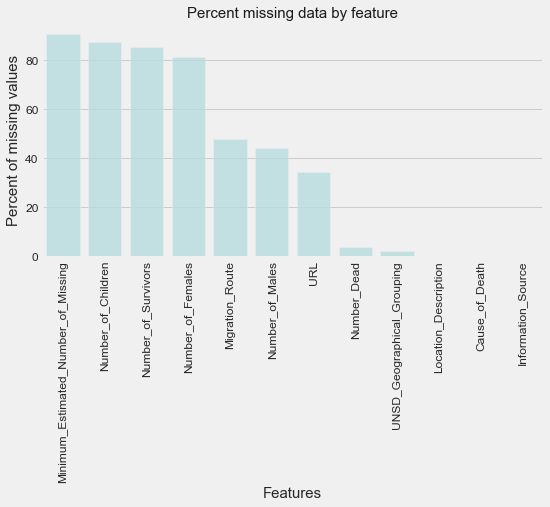

In [5]:

missingData(missingMigrants)

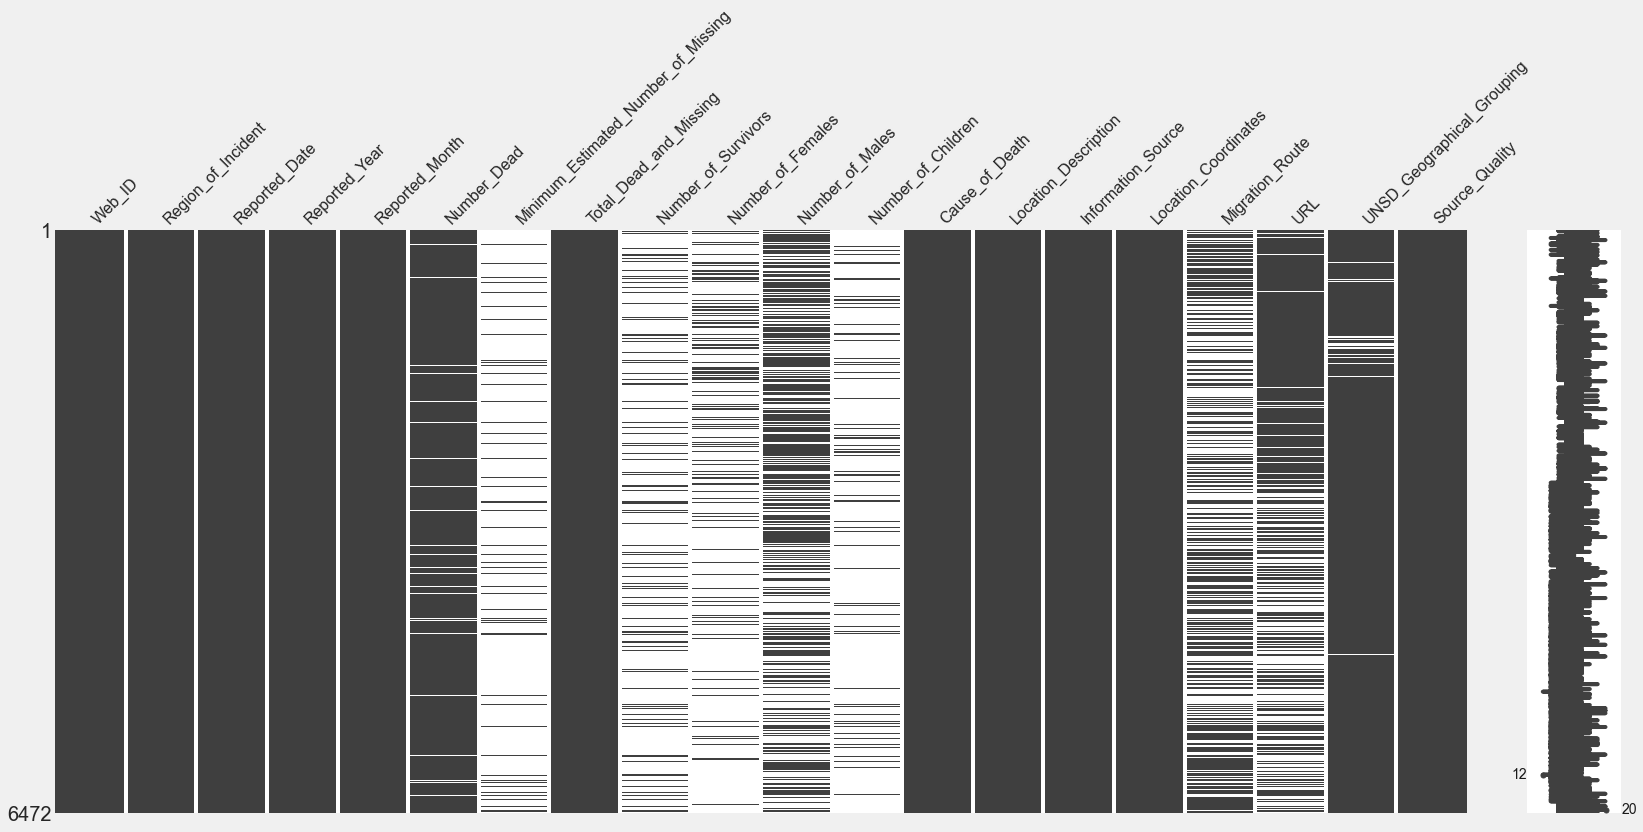

In [6]:
msno.matrix(missingMigrants.head(20000))

Using histigram we Plot the percentage of geneder distribution together in the dataset. it appears that males are more than females 



In [7]:

missingMigrants[['Number_of_Males', 'Number_of_Females']].iplot(
    kind='hist',
    histnorm='percent',
    barmode='overlay',
    xTitle='Gender',
    yTitle='(%) of distribution',
    title='Number_of_Males & Number_of_Females')

Plotting distrinution of Cause_of_Death in Dataset i.e How many records of each Cause_of_Death. It seems that 'Asphyxiatation' or suffocation is a common cause of migrants death. This is probably due to the method of mass transportation that sumgglers used to move migrants. 



In [8]:
missingMigrants['Cause_of_Death'].iplot(kind='scatter', xTitle='count', yTitle='', title='Cause_of_Death Distribution')

**4.Data visulaisation**

in this part we will perform an exploratory data visualisation of several attributes in the dataset. 

Firstly we will split the combined column of "Location_Coordinates" as lat long to get "Latitude and Longitudes" to 

display on map and saving it another dataframe.

We will export the dataframe of this splitting to use later on in our analysis.



In [9]:
df1=missingMigrants.dropna(subset=['Location_Coordinates']) #drop it

df1['lat']=df1['Location_Coordinates'].astype('str').apply(lambda x: x.split(',')).map(lambda x: x[0]).astype('float64') 
df1['long']=df1['Location_Coordinates'].astype('str').apply(lambda x: x.split(',')).map(lambda x: x[-1]).astype('float64')

df1.to_csv(r'MissingMigrantsWithLatLong.csv', index = False)

The majority of reported incidents in the dataset are from Mediterranean,US-Mexico Border,and North Africa regions.

Plotting latitude and longitude, and marking their locations on map, it also displays how many values of a region 

are in dataset

In [10]:

incident_map = folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start =3)
lat_long_data = df1[['lat', 'long']].values.tolist()
cluster_map = folium.plugins.FastMarkerCluster(lat_long_data).add_to(incident_map)

incident_map

 
Highlighted heat map with the regions grouped by total dead and missing migrants. We can clearly see effected regions and also the patterns of incidents. for example, In Africa most North Africa, sub Saharan and East African countries are most affected. most of migrants are passing by a (transit countries) and this is where the density of incidents. 



In [11]:

base_map =  folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start = 3)
HeatMap(data=df1[['lat', 'long']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

base_map

Highlighted heat map where the regions with  Minimum estimated number of missing migrants are reported 
It depicts that mostly migrants are missing near Libyan costs. 'Trablus' is a well known port of smuggling migrants to Europe.


In [12]:


base_map =  folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start = 3)
HeatMap(data=df1[['lat', 'long', 'Minimum_Estimated_Number_of_Missing']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

base_map

Highlighted mapwith regions where Total no of saviours are reported.It appears that most of the migrants survived near Italy.

In [13]:

base_map =  folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start = 3)
HeatMap(data=df1[['lat', 'long', 'Number_of_Survivors']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

base_map

Highlighted map of the regions with Number of dead migrants reported. Sadly, sub Sharan death route (north east Sudan to Libyan costs and Egypt score the highest number of migrant deaths in Africa. Also the path from central America through Mexico to the US have a high rate of mortality.



In [14]:

base_map =  folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start = 3)
HeatMap(data=df1[['lat', 'long', 'Number_Dead']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), name= "Number of deads", radius=8, max_zoom=13).add_to(base_map)

base_map

Highlighted map of regions with Reported over the Years. this is represent the year in which the incident occurred.



In [15]:

base_map =  folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start = 3)
HeatMap(data=df1[['lat', 'long', 'Reported_Year']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8, max_zoom=13 ).add_to(base_map)

base_map


In this step we are converting each unique value in Migration Route to a unique number to display on map. This will help us to explore any unknown route that not heighted previously. For instant we have the route from north Turkey to eastern European countries which heavily used by migrants during the Syrian crisis. Also, the famous route from north France (Calais) to UK.

 



In [16]:

df1['Migration_Route_numeric'] = df1['Migration_Route'].map({'nan': 0, 'Western Mediterranean': 1, 'Eastern Mediterranean': 2,
'Western African': 3, 'Central America to US': 4, 'Western Balkans': 5,
'Central Mediterranean': 6, 'Horn Africa to Yemen': 7, 'Italy to France': 8,
'Calais to United Kingdom': 9, 'Darien Gap': 10,
'Dominican Republic to Puerto Rico': 11, 'Malaysia to Indonesia': 12,
'From Haiti to Dajabon, Dominican Republic': 13,
'Caribbean to Central America': 14, 'Venezuela to Curaçao': 15})

In [17]:

base_map =  folium.Map(location = [df1['lat'].mean(), df1['long'].mean()], zoom_start = 3)
HeatMap(data=df1[['lat', 'long', 'Migration_Route_numeric']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8,  max_zoom=13 ).add_to(base_map)

base_map

Displaying all the regions on an interactive map. It displays more details  such as, no. of deads, missings,
males, females, children, and the sources of informartion.

In [18]:


fig = px.scatter_mapbox(df1, lat="lat", lon="long", hover_name="Region_of_Incident", hover_data=["Cause_of_Death", "Information_Source", "Number_Dead", "Total_Dead_and_Missing", "Number_of_Survivors", "Number_of_Females", "Number_of_Males", "Number_of_Children"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=500)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In this step we are displaying the number of records per Region of incident in the dataset.Incident regions Central Asia, Sub-Saharan Africa, and Central America have most of the records in dataset.

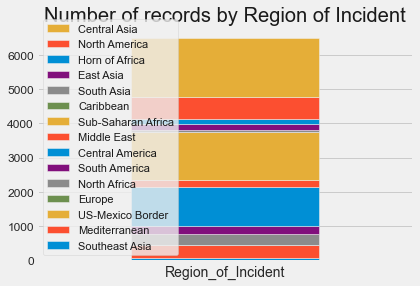

In [19]:

missingMigrants.assign(dummy = 1).groupby(['dummy','Region_of_Incident']).size().to_frame().unstack().plot(kind='bar',stacked=True,legend=False)

plt.title('Number of records by Region of Incident')

# other it'll show up as 'dummy' 
plt.xlabel('Region_of_Incident')

# disable ticks in the x axis
plt.xticks([])

# fix the legend
current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)

labels = reversed(missingMigrants['Region_of_Incident'].unique())

plt.legend(reversed_handles,labels, loc='  right')
plt.show()

This display several possible values in the given column and how often they occur. In term of source of information in this dataset Mixed Migration Monitoring Mechanism centre (4Mi) is mostly occurring Info source. (4Mi) is well known monitor of collecting data directly from refugees and migrants on the move. [http://www.mixedmigration.org/4mi/]



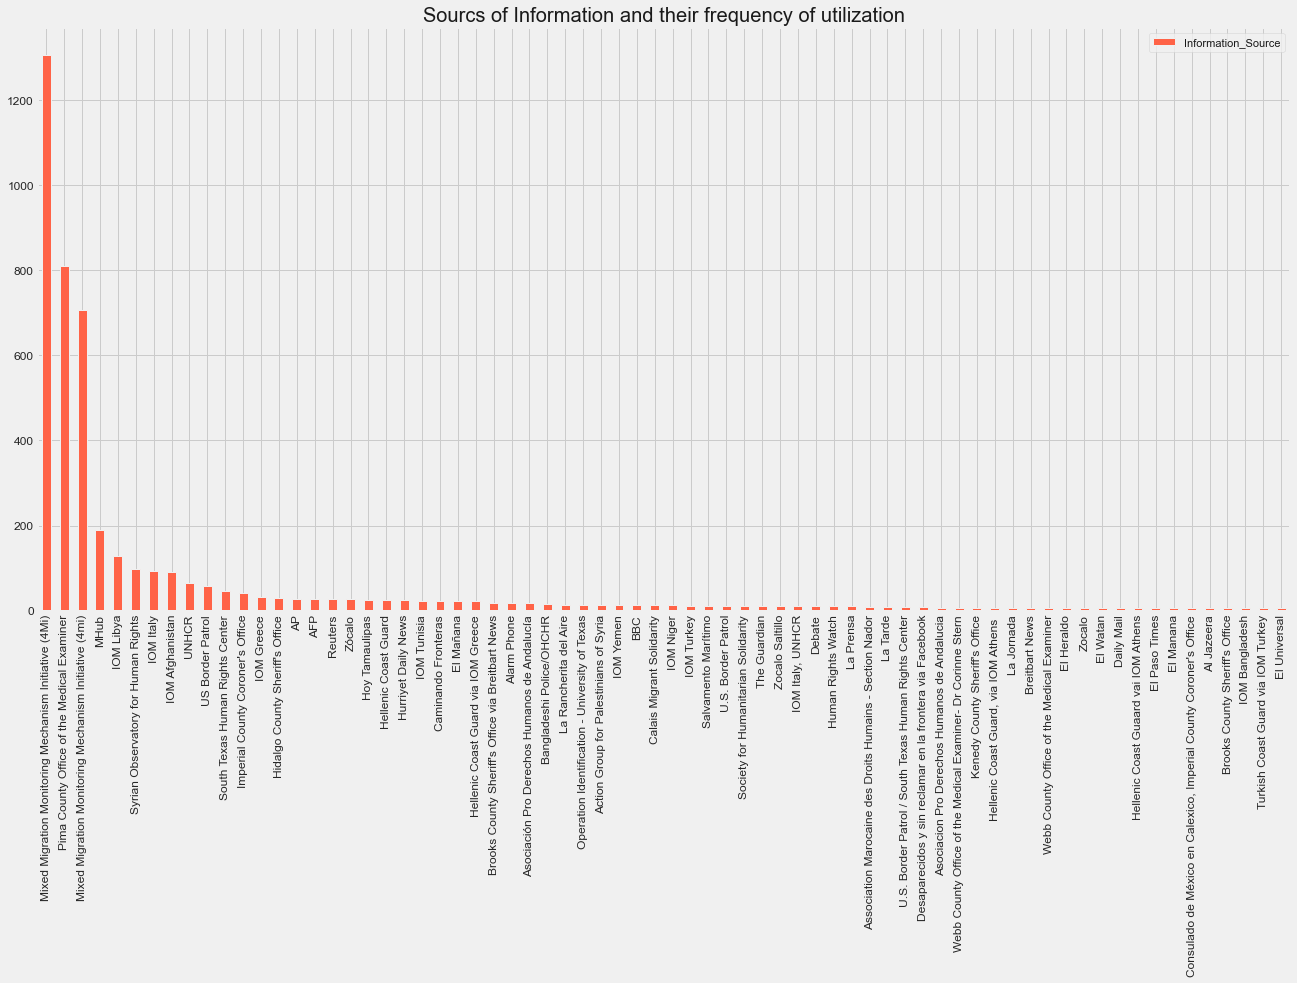

In [20]:

missingMigrants['Information_Source'].value_counts()[:70].plot(kind='bar',linewidth=1.0, color='tomato',figsize=[20, 10], title = "Sourcs of Information and their frequency of utilization", legend = "True")

A display of several possible values in the given column and how often they occur. it shows the most occurring  causes of death.  Drowning or sickness are the most frequent causes of causes of death 

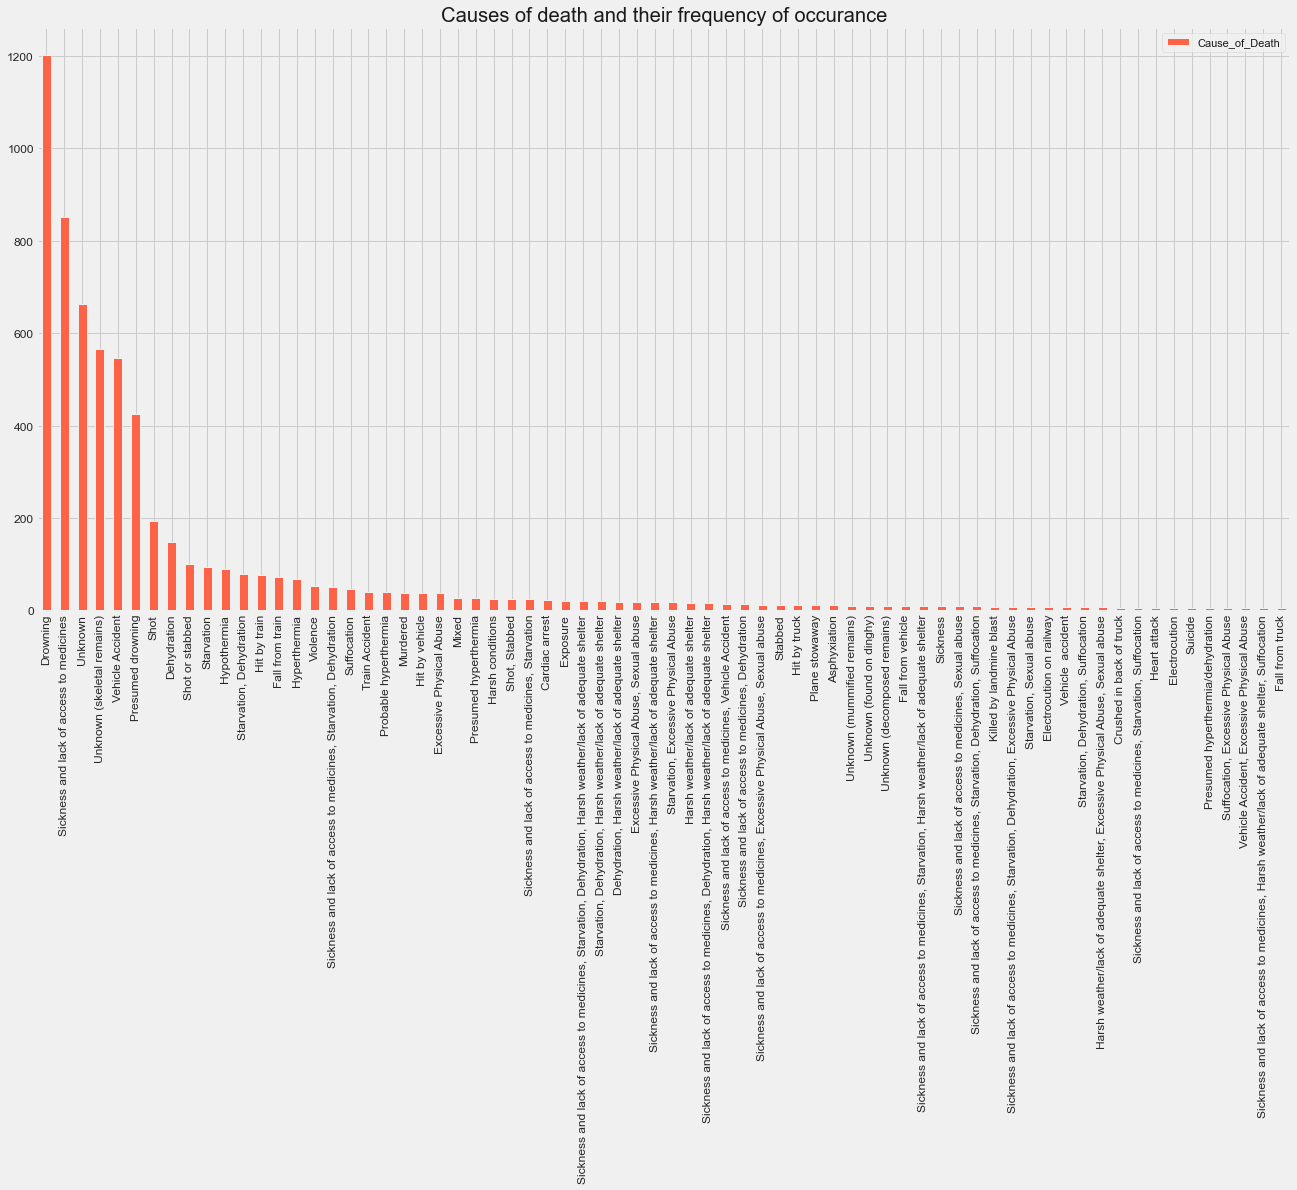

In [21]:

missingMigrants['Cause_of_Death'].value_counts()[:70].plot(kind='bar',figsize=[20, 10],linewidth=1.0,color='tomato',title = "Causes of death and their frequency of occurance", legend = "True")

#Frequency of males and females in each Region of Incident. It shows that there are more male migrants than female migrants

*** the argument  gca stands for 'get current axis***

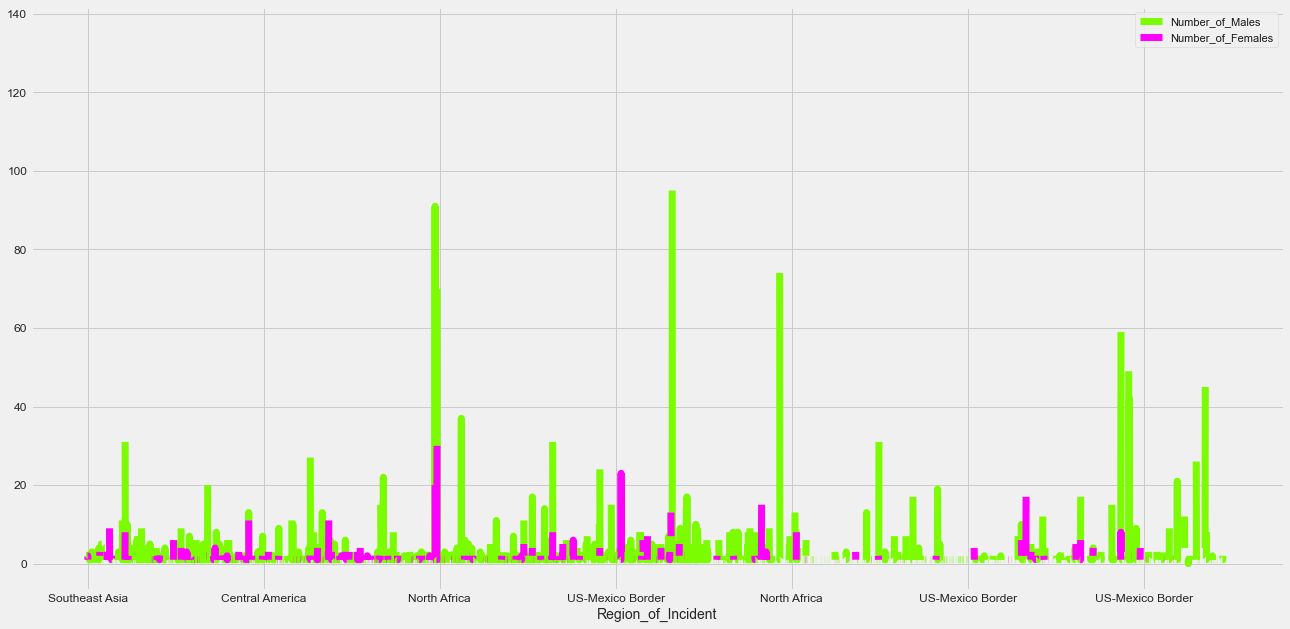

In [22]:

ax = plt.gca()

missingMigrants.plot(kind='line',x='Region_of_Incident',y='Number_of_Males',linewidth=7.0,figsize=[20, 10],color='lawngreen',legend = "True",ax=ax)
missingMigrants.plot(kind='line',x='Region_of_Incident',y='Number_of_Females',linewidth=7.0,figsize=[20, 10],color='fuchsia',legend = "True", ax=ax)

plt.show()



To see whether there is any correlation between Number Dead and other variables. We will do this using a pairgrid,

which draws plots of all these correlations:

#These graphs show that how change in one column's value effects value in other column. 

We can observe that between year 2015 is correlated with high number of incidents in Mediterranean and southeast and central Asia regions. Also, the number of death is increasingly high in sub Saharan Africa.


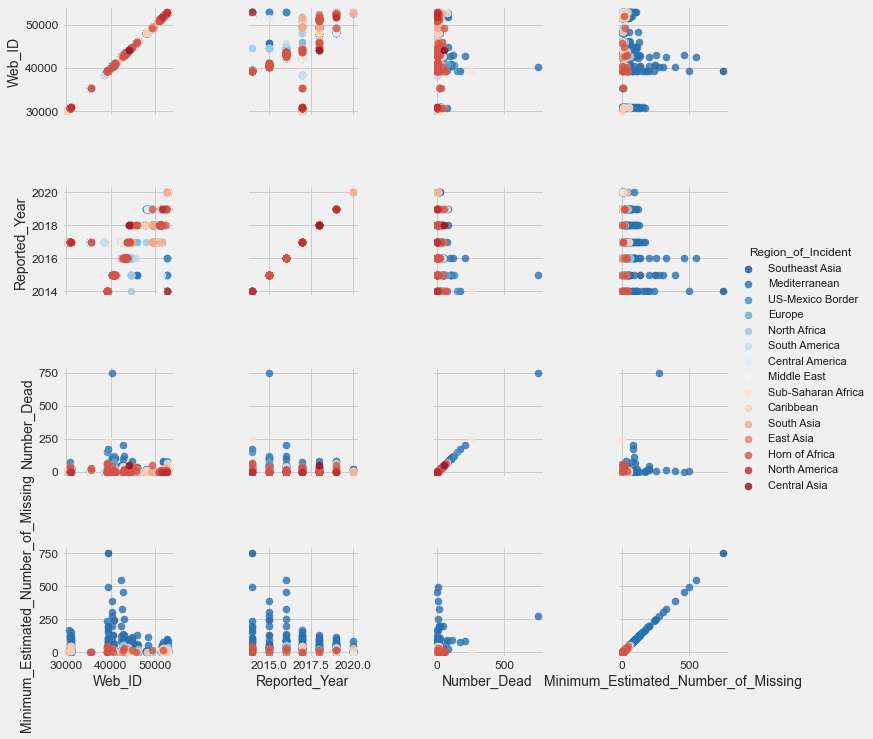

In [23]:

g = sns.PairGrid(missingMigrants, vars=['Web_ID', 'Reported_Year', 'Number_Dead', 'Minimum_Estimated_Number_of_Missing'],
                 hue='Region_of_Incident', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8,s=50)
g.add_legend();

Displaying how many migrants dead each year, it shows most of them dead in 2015



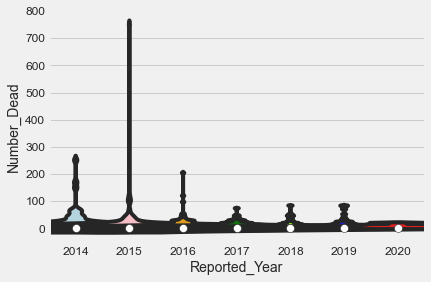

In [24]:

sns.violinplot("Reported_Year", "Number_Dead", data=missingMigrants, gridsize=10000,width=100,figsize=[2000, 1000],palette=["lightblue", "lightpink", "orange", "green", "chartreuse", "blue", "red"]);
sns.set_style('ticks')

A scatter plot comparing Number of Dead migrants with respect to years , it also proves most of migrants death occur in 2015



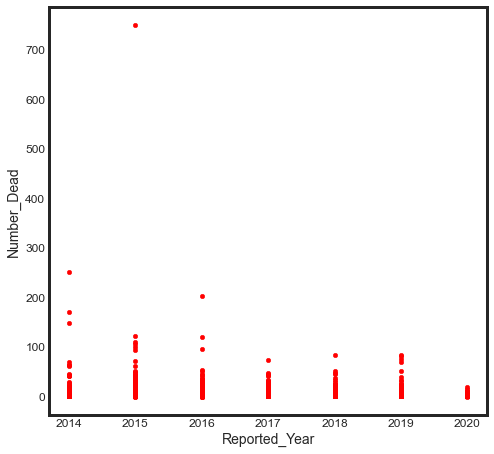

In [25]:
missingMigrants.plot(kind='scatter', x='Reported_Year',y='Number_Dead',figsize=[7,7],color='red')

plt.show()


Correlation between features. Graphs along the left diagonal represent the distribution of each feature, 
whilst graphs on off diagonals show the relationship between variables.

Major observation:

increasing number female surviving comparing to males who has flattered curve in minimum Estimated number of missing.




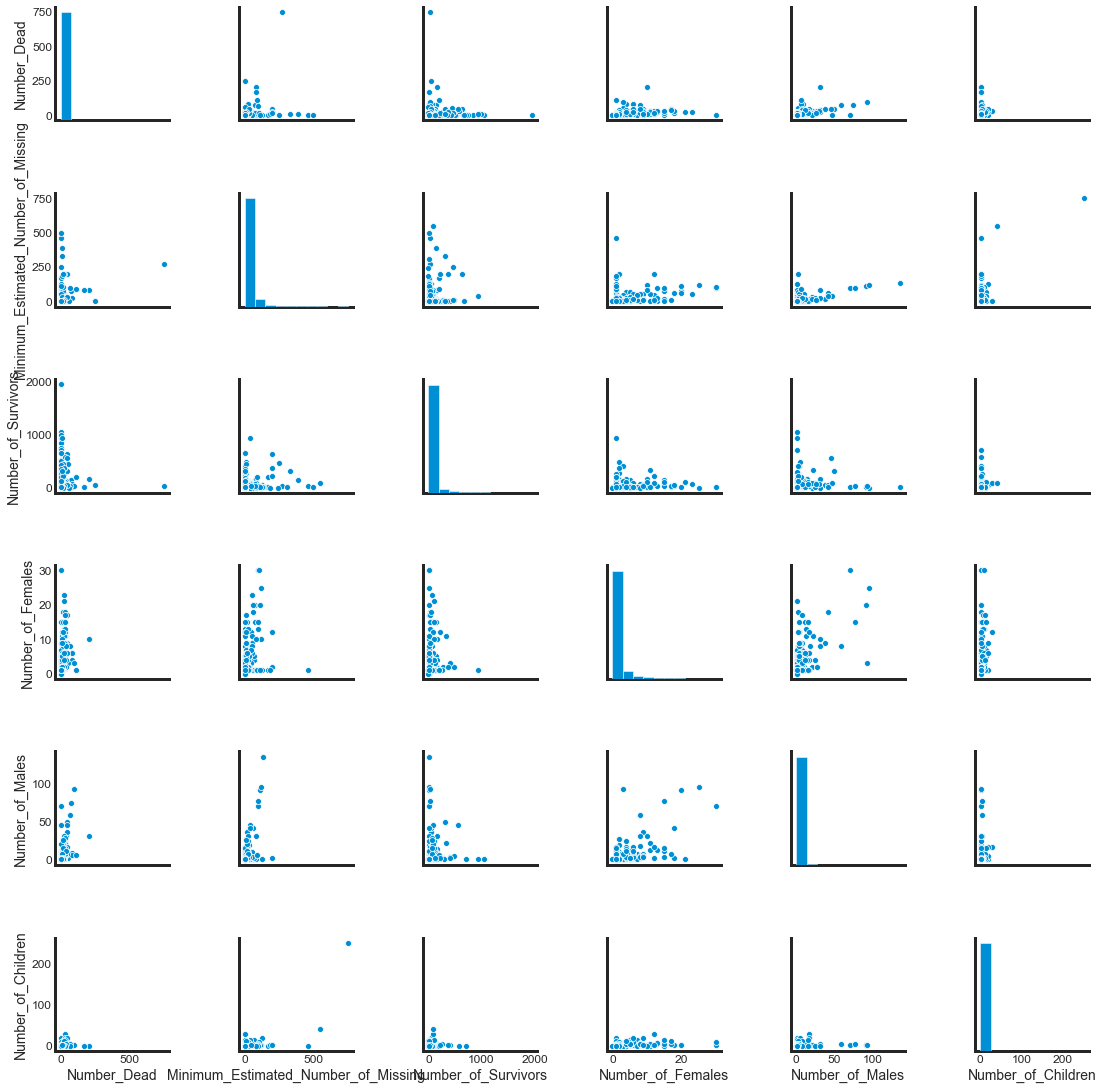

In [26]:

sns.pairplot(missingMigrants.loc[:,missingMigrants.dtypes == 'float64'])

Using the Heatmap for example we can observe that 
1. Source quality is positively coorrelayed with number of females 
2. Number of males is positively coorelated with Minimum estimate number of missing and also with the number of dead and number of childrens 


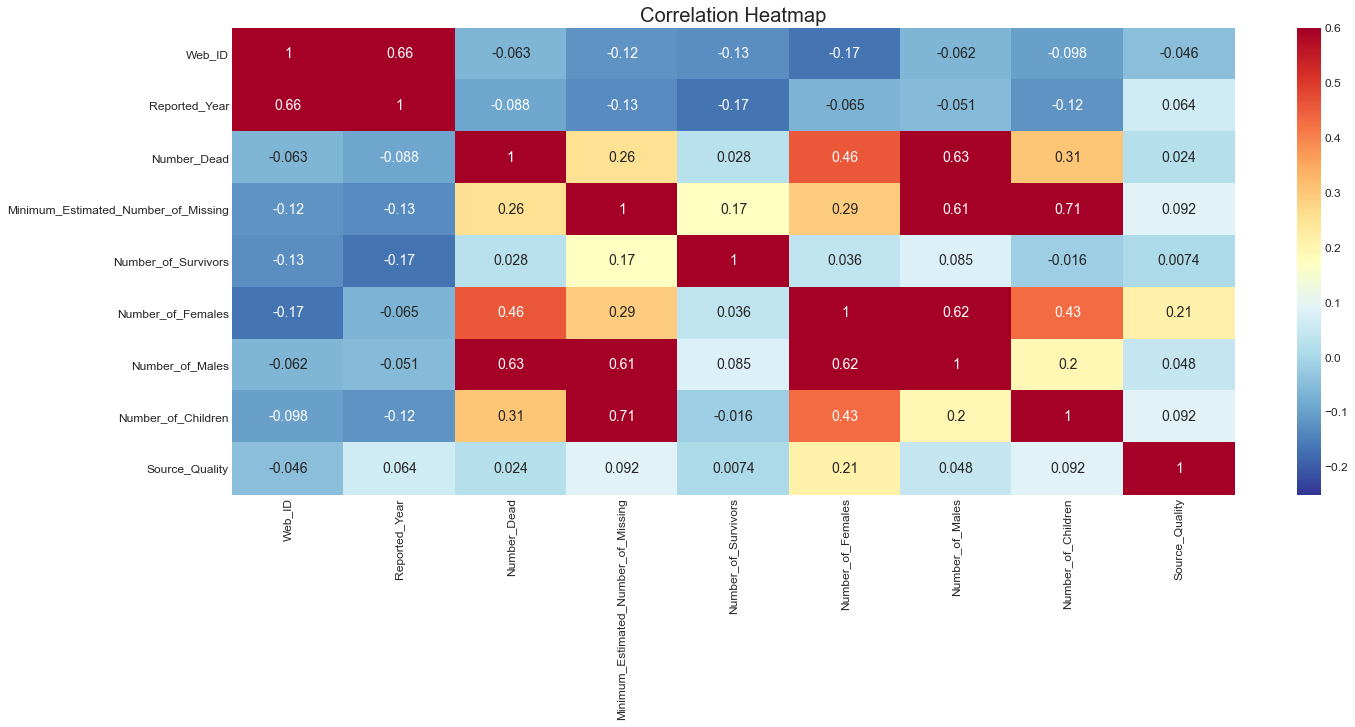

In [27]:
corrs = missingMigrants.corr()
plt.figure(figsize = (20, 8))
# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Plotted number of migrants death with repect to Region of incidents
Shows that mostly migrants dead in Region SouthEast Asia
we are plotting values for only first 30 rows.

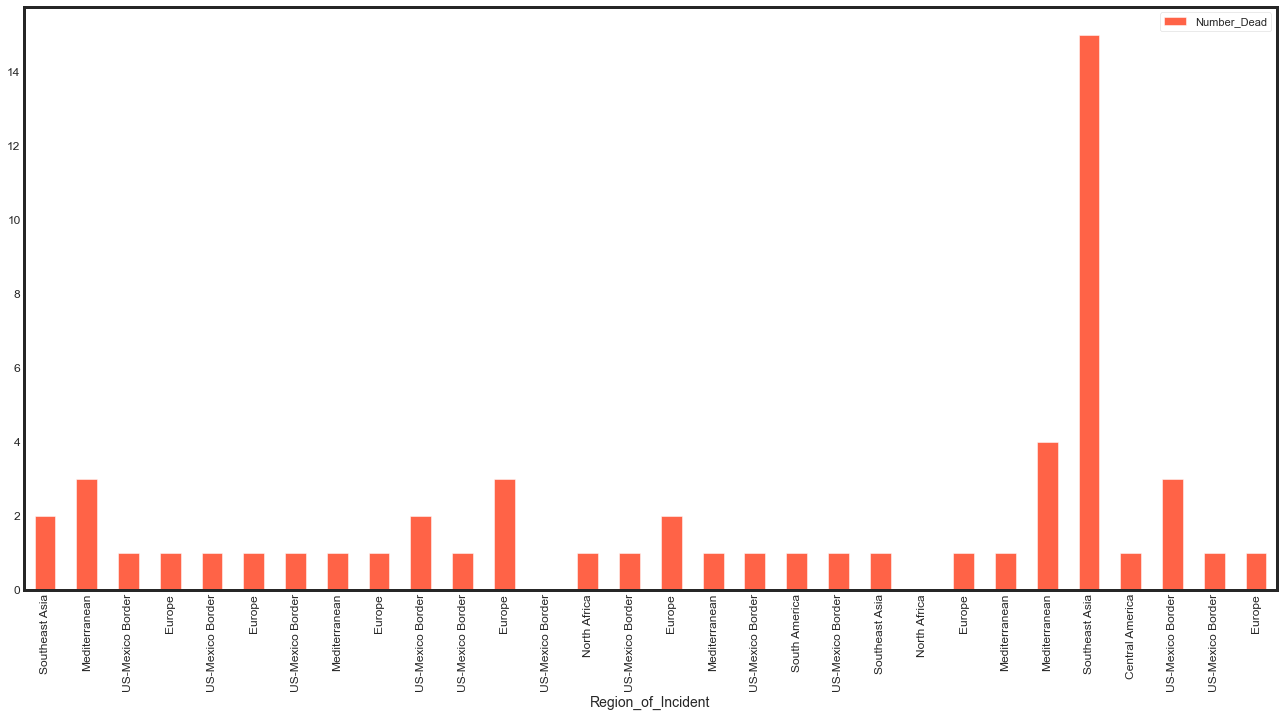

In [28]:
missingMigrants[:30].plot(kind='bar',x='Region_of_Incident',y='Number_Dead',figsize=[20, 10],color='tomato')    

Grouped Dead and missing migrants with respect to Region of incident

Meditteranean has the most number of total dead ad missing

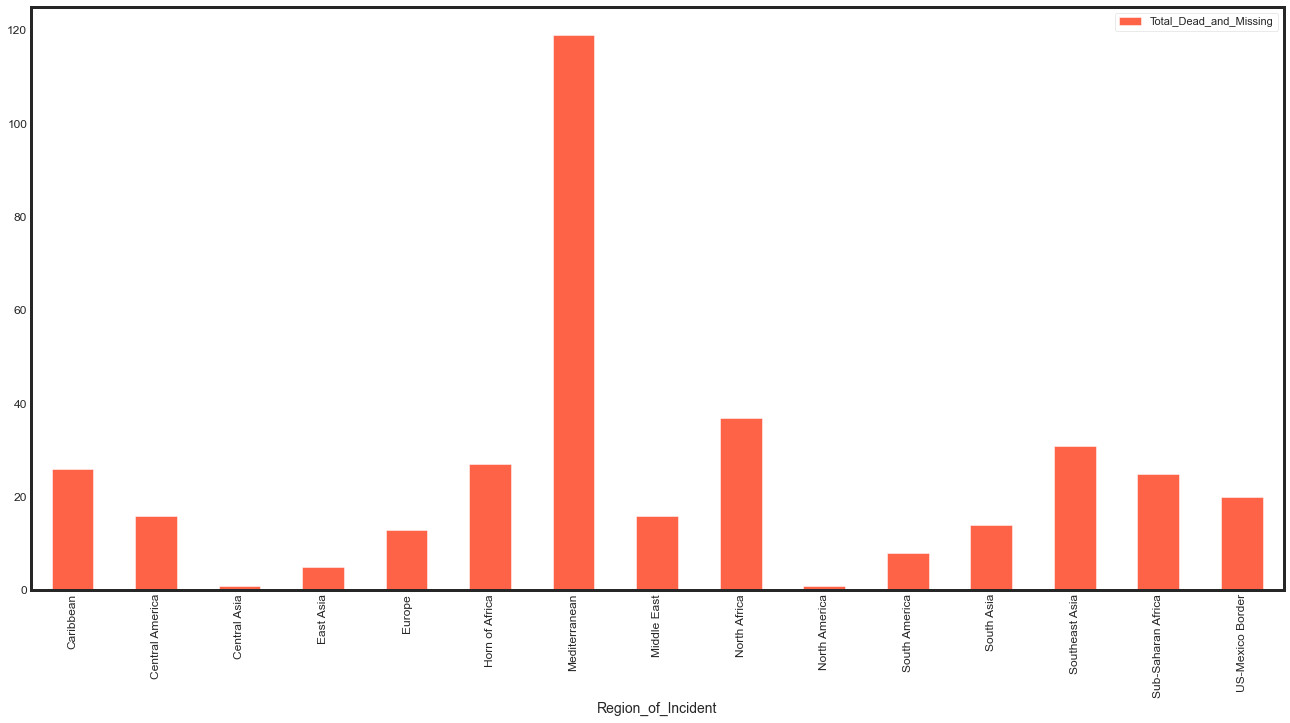

In [29]:
missingMigrants.groupby('Region_of_Incident')['Total_Dead_and_Missing'].nunique().plot(kind='bar',figsize=[20, 10],color='tomato', legend = "True")
plt.show()

Displaying Region of incidents effected by cause of death

It surprisingly show that dying Shot effected Europe 

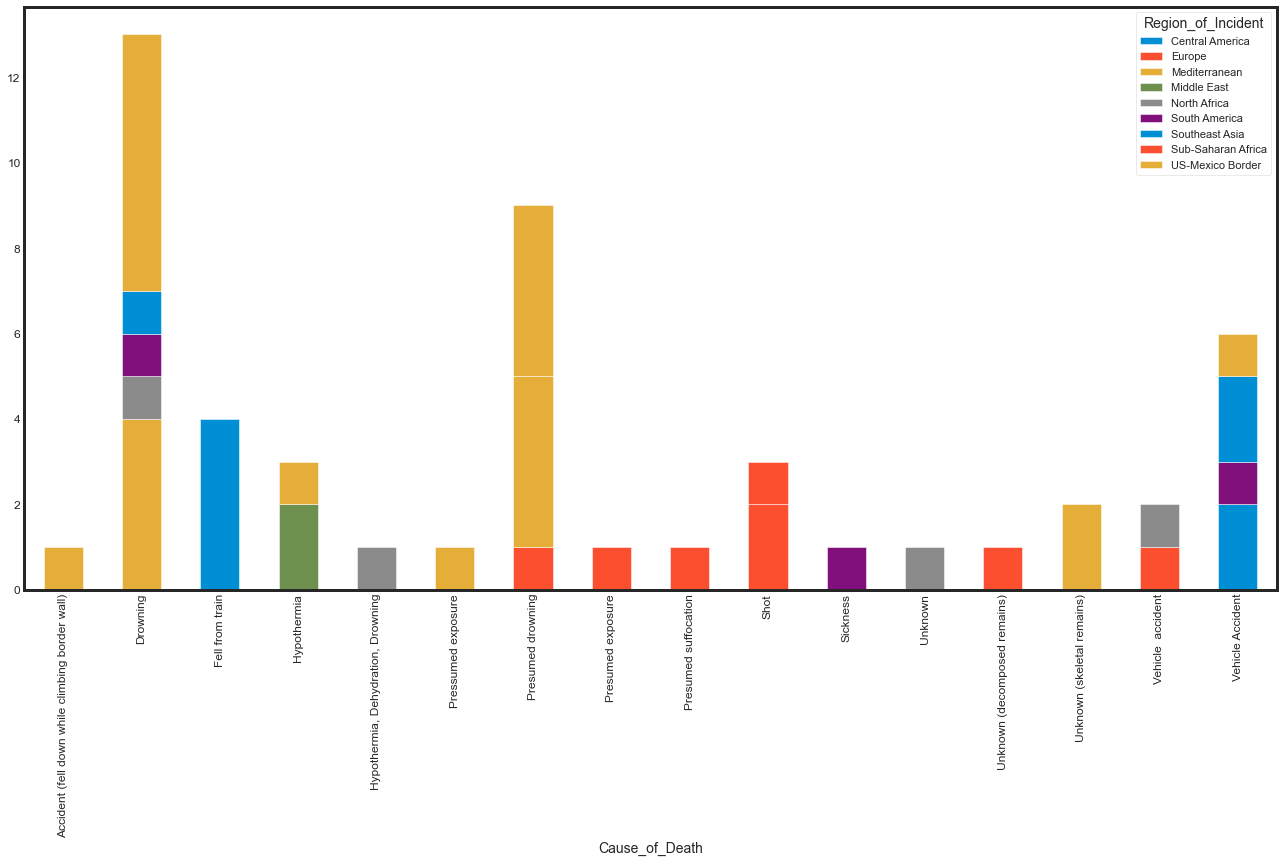

In [30]:
missingMigrants[:50].groupby(['Cause_of_Death', 'Region_of_Incident',]).size().unstack().plot(kind='bar',figsize=[20, 10],stacked=True)
plt.show()

Displaying Region of incidents effected by cause of death (Same as above, just swapped the axis)



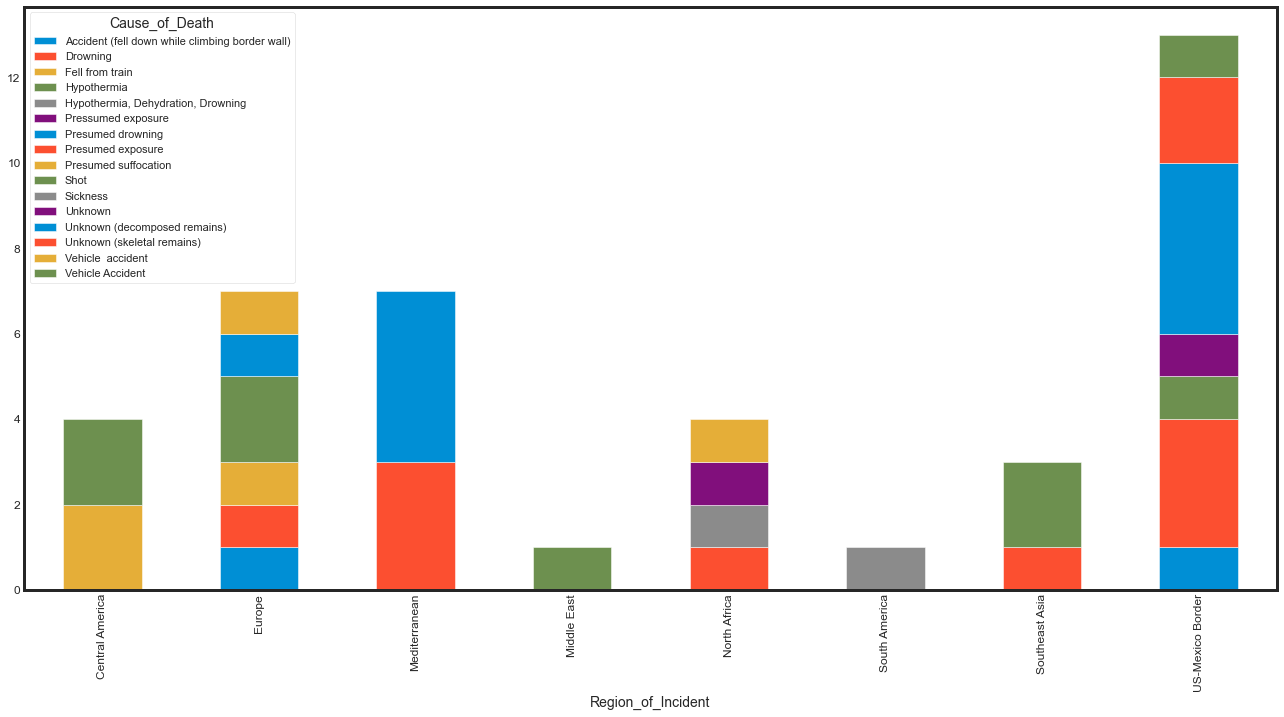

In [31]:


missingMigrants[:40].groupby(['Region_of_Incident', 'Cause_of_Death']).size().unstack().plot(kind='bar',stacked=True, figsize=[20, 10])
plt.show()

**4 Data cleaning**



Now we sort our data by selecting only colums relevant to our analysis. This could help us later on our prediction models.

In [32]:
missingMigrants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6472 entries, 0 to 6471
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Web_ID                               6472 non-null   int64  
 1   Region_of_Incident                   6472 non-null   object 
 2   Reported_Date                        6472 non-null   object 
 3   Reported_Year                        6472 non-null   int64  
 4   Reported_Month                       6472 non-null   object 
 5   Number_Dead                          6227 non-null   float64
 6   Minimum_Estimated_Number_of_Missing  614 non-null    float64
 7   Total_Dead_and_Missing               6472 non-null   object 
 8   Number_of_Survivors                  955 non-null    float64
 9   Number_of_Females                    1217 non-null   float64
 10  Number_of_Males                      3603 non-null   float64
 11  Number_of_Children            

Then we will use this Methods to calculate and display missing values

In this step we are calculating and displaying percentage of all the missing entries in each column

by observing the the outcome of  the two below lines it appear that we have many colmn with missing values in particular the cloumn with the name (Minimum_Estimated_Number_of_Missing) has the highest precentage of missing values.Therefore, we will try to sort our data by using those those columns most important to our analysis.




In [33]:
total = missingMigrants.isnull().sum().sort_values(ascending = False)
percent = (missingMigrants.isnull().sum()/missingMigrants.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(10)

Total    Percent
Minimum_Estimated_Number_of_Missing   5858  90.512979
Number_of_Children                    5654  87.360939
Number_of_Survivors                   5517  85.244129
Number_of_Females                     5255  81.195921
Migration_Route                       3104  47.960445
Number_of_Males                       2869  44.329419
URL                                   2240  34.610630
Number_Dead                            245   3.785538
UNSD_Geographical_Grouping             147   2.271323
Location_Description                     9   0.139061

Apprently the column of Minimum_Estimated_Number_of_Missing has the highest number of missing values 

So since there are too many missing values .We will sort our data by using only those columns those are more important  



In [34]:
df0 = missingMigrants[['Web_ID','Region_of_Incident',
         'Reported_Date', 
         'Total_Dead_and_Missing',
         'Number_of_Survivors', 
        'Cause_of_Death',
        'Location_Description',
        'Information_Source',
        'Location_Coordinates',
        'Migration_Route',
        'URL','UNSD_Geographical_Grouping']]

In [35]:
df0.head()

Web_ID Region_of_Incident Reported_Date Total_Dead_and_Missing  \
0   52932     Southeast Asia     14-Mar-20                      2   
1   52931      Mediterranean     12-Mar-20                      8   
2   52924   US-Mexico Border     10-Mar-20                      1   
3   52923             Europe      8-Mar-20                      1   
4   52922   US-Mexico Border      7-Mar-20                      1   

   Number_of_Survivors                                   Cause_of_Death  \
0                  5.0                                 Vehicle Accident   
1                 39.0                                         Drowning   
2                  NaN  Accident (fell down while climbing border wall)   
3                  NaN                                Presumed drowning   
4                  NaN                                Presumed drowning   

                                Location_Description  \
0                 Nikhom Phatthana, Rayong, Thailand   
1                  Off the coast of Larache, Morocco   
2                El Paso, El paso County, Texas, USA   
3              Evros/Meriç river, near Feres, Greece   
4  Body recovered from the Río Bravo at Nuevo Lar...   

                 Information_Source                Location_Coordinates  \
0                      Bangkok Post   12.829911400000, 101.204333300000   
1               Caminando Fronteras    35.189860435378, -6.173145606543   
2  US Customs and Border Protection  31.761877800000, -106.485021700000   
3                      Ekathimerini    40.904620957060, 26.255972451953   
4                  Noticias Reynosa   27.496971556610, -99.528372819946   

         Migration_Route                       URL UNSD_Geographical_Grouping  
0                    NaN    https://bit.ly/3aYbyfW         South-eastern Asia  
1  Western Mediterranean  https://archive.ph/gB4Vs              Uncategorized  
2                    NaN    https://bit.ly/33b78ji           Northern America  
3                    NaN  https://archive.ph/pZZd2            Southern Europe  
4                    NaN    https://bit.ly/2VZlly3            Central America

#### Using dropna function ,we will remove those rows ,which have missing data

In [36]:
df0.dropna()

Web_ID Region_of_Incident Reported_Date Total_Dead_and_Missing  \
1      52931      Mediterranean     12-Mar-20                      8   
7      52907      Mediterranean      2-Mar-20                      1   
13     52909       North Africa     27-Feb-20                      1   
21     52894       North Africa     17-Feb-20                     14   
34     52877       North Africa      8-Feb-20                      9   
...      ...                ...           ...                    ...   
6443   39229     Horn of Africa     26-Feb-14                     17   
6449   39211   US-Mexico Border     18-Feb-14                      1   
6450   39228      Mediterranean     17-Feb-14                      2   
6455   39404      Mediterranean      6-Feb-14                     15   
6457   39373             Europe     30-Jan-14                      1   

      Number_of_Survivors                      Cause_of_Death  \
1                    39.0                            Drowning   
7                    47.0                   Presumed drowning   
13                   34.0                             Unknown   
21                   14.0                            Drowning   
34                   18.0  Hypothermia, Dehydration, Drowning   
...                   ...                                 ...   
6443                  0.0                            Drowning   
6449                  2.0                                Shot   
6450                121.0                             Unknown   
6455                  0.0                                Shot   
6457                  2.0                    Vehicle Accident   

                                   Location_Description  \
1                     Off the coast of Larache, Morocco   
7                       Off the coast of Lesbos, Greece   
13    Unspecified location close to Matorral, Castil...   
21    Off the coast of Dakhla, Morocco - en route to...   
34      800km south of El Hierro, Canary Islands, Spain   
...                                                 ...   
6443                  Gulf of Aden (left from Djibouti)   
6449            California-Mexico border near San Diego   
6450                                       Italy waters   
6455                                       Ceuta waters   
6457                                    France - Calais   

                            Information_Source  \
1                          Caminando Fronteras   
7     Hellenic Coast Guard, Reuters, RT Arabic   
13                   El País, Diario Siglo XXI   
21            Alarm Phone, Caminando Fronteras   
34            Caminando Fronteras, eldiario.es   
...                                        ...   
6443                                       IOM   
6449                                       CNN   
6450                               Malta Today   
6455                                L'Espresso   
6457                Calais Migrant Solidarity    

                    Location_Coordinates           Migration_Route  \
1       35.189860435378, -6.173145606543     Western Mediterranean   
7       39.271420260806, 26.392377099805     Eastern Mediterranean   
13     27.800645499852, -15.438462005127           Western African   
21     24.511272338990, -16.862474265116           Western African   
34     25.377246148104, -18.573617406250           Western African   
...                                  ...                       ...   
6443    20.280200000000, 38.512600000000      Horn Africa to Yemen   
6449  32.554300000000, -117.052000000000     Central America to US   
6450    34.564500000000, 15.886200000000     Central Mediterranean   
6455    35.879300000000, -5.364070000000     Western Mediterranean   
6457     50.935500000000, 1.878660000000  Calais to United Kingdom   

                                                    URL  \
1                              https://archive.ph/gB4Vs   
7     http://www.hcg.gr/node/22624, https://bit.ly/3...   
13       https://bit.ly/397IL8v,

Check if there are duplicated rows and remove if any

In [37]:
df0[df0['Web_ID'].duplicated()]

Empty DataFrame
Columns: [Web_ID, Region_of_Incident, Reported_Date, Total_Dead_and_Missing, Number_of_Survivors, Cause_of_Death, Location_Description, Information_Source, Location_Coordinates, Migration_Route, URL, UNSD_Geographical_Grouping]
Index: []

#### Change the format of  'Reported Date' column to datetime format

In [38]:
df0['Reported_Date'] = pd.to_datetime(df0['Reported_Date'], infer_datetime_format=True)

**Inspect rows with no 'Total Dead and Missing'**

In [39]:
df0[df0['Total_Dead_and_Missing']==0]

Empty DataFrame
Columns: [Web_ID, Region_of_Incident, Reported_Date, Total_Dead_and_Missing, Number_of_Survivors, Cause_of_Death, Location_Description, Information_Source, Location_Coordinates, Migration_Route, URL, UNSD_Geographical_Grouping]
Index: []

 We will total Dead and Missing' according to information from available URL**

In [40]:
df0['Total_Dead_and_Missing'][4599]=11
df0['Total_Dead_and_Missing'][5013]=6

**5 Feature engineering**



Adding a row of to sum 'Total Dead and Missing' and 'Number of Survivors' we can then use the new coloumn to view the trends of migrants and corresponding death/missing over Time. 
However bas coloumn Total_Dead_and_Missing is (object)  we need to convert it to (Int) before we can use it to sum total migrants attribues. we will use factorise function in pandas for conversion.


In [41]:
df0.Total_Dead_and_Missing= pd.factorize(df0.Total_Dead_and_Missing)[0]

In [42]:
df0['Total Migrants']  = df0['Total_Dead_and_Missing'] + df0['Number_of_Survivors']

df0

Web_ID Region_of_Incident Reported_Date  Total_Dead_and_Missing  \
0      52932     Southeast Asia    2020-03-14                       0   
1      52931      Mediterranean    2020-03-12                       1   
2      52924   US-Mexico Border    2020-03-10                       2   
3      52923             Europe    2020-03-08                       2   
4      52922   US-Mexico Border    2020-03-07                       2   
...      ...                ...           ...                     ...   
6467   39207   US-Mexico Border    2014-01-16                       2   
6468   39368             Europe    2014-01-16                       2   
6469   39257   US-Mexico Border    2014-01-14                       2   
6470   39256   US-Mexico Border    2014-01-12                       2   
6471   39206   US-Mexico Border    2014-01-06                       2   

      Number_of_Survivors                                   Cause_of_Death  \
0                     5.0                                 Vehicle Accident   
1                    39.0                                         Drowning   
2                     NaN  Accident (fell down while climbing border wall)   
3                     NaN                                Presumed drowning   
4                     NaN                                Presumed drowning   
...                   ...                                              ...   
6467                  NaN                                             Shot   
6468                  2.0                                     Hyperthermia   
6469                  NaN                       Unknown (skeletal remains)   
6470                  NaN                       Unknown (skeletal remains)   
6471                  NaN                       Unknown (skeletal remains)   

                                   Location_Description  \
0                    Nikhom Phatthana, Rayong, Thailand   
1                     Off the coast of Larache, Morocco   
2                   El Paso, El paso County, Texas, USA   
3                 Evros/Meriç river, near Feres, Greece   
4     Body recovered from the Río Bravo at Nuevo Lar...   
...                                                 ...   
6467                              near Douglas, Arizona   
6468                  Border between Russia and Estonia   
6469                                        Pima County   
6470                                        Pima County   
6471                                        Pima County   

                               Information_Source  \
0                                    Bangkok Post   
1                             Caminando Fronteras   
2                US Customs and Border Protection   
3                                    Ekathimerini   
4                                Noticias Reynosa   
...                                           ...   
6467           Ministry of Foreign Affairs Mexico   
6468            EUBusiness (Agence France-Presse)   
6469   Pima County Office of the Medical Examiner   
6470   Pima County Office of the Medical Examiner   
6471  Humane Borders Arizona Open GIS Initiative    

                    Location_Coordinates        Migration_Route  \
0      12.829911400000, 101.204333300000                    NaN   
1       35.189860435378, -6.173145606543  Western Mediterranean   
2     31.761877800000, -106.485021700000                    NaN   
3       40.904620957060, 26.255972451953                    NaN   
4      27.496971556610, -99.528372819946                    NaN   
...                                  ...                    ...   
6467  31.344700000000, -109.545000000000  Central America to US   
6468    59.155100000000, 27.858600000000                    NaN   
6469  32.058118300000, -111.623576100000  Central America to US   
6470  32.058118300000, -111.623576100000  Central America to US   
6471  32.058118300000, -111.623576100000  Central America to US   

                             URL UNSD_Geo

then we clean dropNA from our new column 

In [43]:
df0.dropna()

Web_ID Region_of_Incident Reported_Date  Total_Dead_and_Missing  \
1      52931      Mediterranean    2020-03-12                       1   
7      52907      Mediterranean    2020-03-02                       2   
13     52909       North Africa    2020-02-27                       2   
21     52894       North Africa    2020-02-17                       5   
34     52877       North Africa    2020-02-08                      10   
...      ...                ...           ...                     ...   
6443   39229     Horn of Africa    2014-02-26                      17   
6449   39211   US-Mexico Border    2014-02-18                       2   
6450   39228      Mediterranean    2014-02-17                       0   
6455   39404      Mediterranean    2014-02-06                      39   
6457   39373             Europe    2014-01-30                       2   

      Number_of_Survivors                      Cause_of_Death  \
1                    39.0                            Drowning   
7                    47.0                   Presumed drowning   
13                   34.0                             Unknown   
21                   14.0                            Drowning   
34                   18.0  Hypothermia, Dehydration, Drowning   
...                   ...                                 ...   
6443                  0.0                            Drowning   
6449                  2.0                                Shot   
6450                121.0                             Unknown   
6455                  0.0                                Shot   
6457                  2.0                    Vehicle Accident   

                                   Location_Description  \
1                     Off the coast of Larache, Morocco   
7                       Off the coast of Lesbos, Greece   
13    Unspecified location close to Matorral, Castil...   
21    Off the coast of Dakhla, Morocco - en route to...   
34      800km south of El Hierro, Canary Islands, Spain   
...                                                 ...   
6443                  Gulf of Aden (left from Djibouti)   
6449            California-Mexico border near San Diego   
6450                                       Italy waters   
6455                                       Ceuta waters   
6457                                    France - Calais   

                            Information_Source  \
1                          Caminando Fronteras   
7     Hellenic Coast Guard, Reuters, RT Arabic   
13                   El País, Diario Siglo XXI   
21            Alarm Phone, Caminando Fronteras   
34            Caminando Fronteras, eldiario.es   
...                                        ...   
6443                                       IOM   
6449                                       CNN   
6450                               Malta Today   
6455                                L'Espresso   
6457                Calais Migrant Solidarity    

                    Location_Coordinates           Migration_Route  \
1       35.189860435378, -6.173145606543     Western Mediterranean   
7       39.271420260806, 26.392377099805     Eastern Mediterranean   
13     27.800645499852, -15.438462005127           Western African   
21     24.511272338990, -16.862474265116           Western African   
34     25.377246148104, -18.573617406250           Western African   
...                                  ...                       ...   
6443    20.280200000000, 38.512600000000      Horn Africa to Yemen   
6449  32.554300000000, -117.052000000000     Central America to US   
6450    34.564500000000, 15.886200000000     Central Mediterranean   
6455    35.879300000000, -5.364070000000     Western Mediterranean   
6457     50.935500000000, 1.878660000000  Calais to United Kingdom   

                                                    URL  \
1                              https://archive.ph/gB4Vs   
7     http://www.hcg.gr/node/22624, https://bit.ly/3...   
13       https://bit

**Trends of migrants and corresponding death/missing over Time**

In [44]:
df_temp = df0.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
df_temp['Reported_Month']=df_temp['Reported_Date'].dt.strftime('%Y-%m')
df_temp = df_temp.groupby('Reported_Month')['Total_Dead_and_Missing'].sum().reset_index()

In [45]:
df_temp = df0.groupby('Reported_Date')['Total_Dead_and_Missing','Total Migrants'].sum().reset_index()
df_temp['Reported_Month']=df_temp['Reported_Date'].dt.strftime('%Y-%m')
df_temp = df_temp.groupby('Reported_Month')['Total_Dead_and_Missing','Total Migrants'].sum().reset_index()

**Total Dead and Missing Migrants over time**

Text(0, 0.5, 'No. of Migrants')

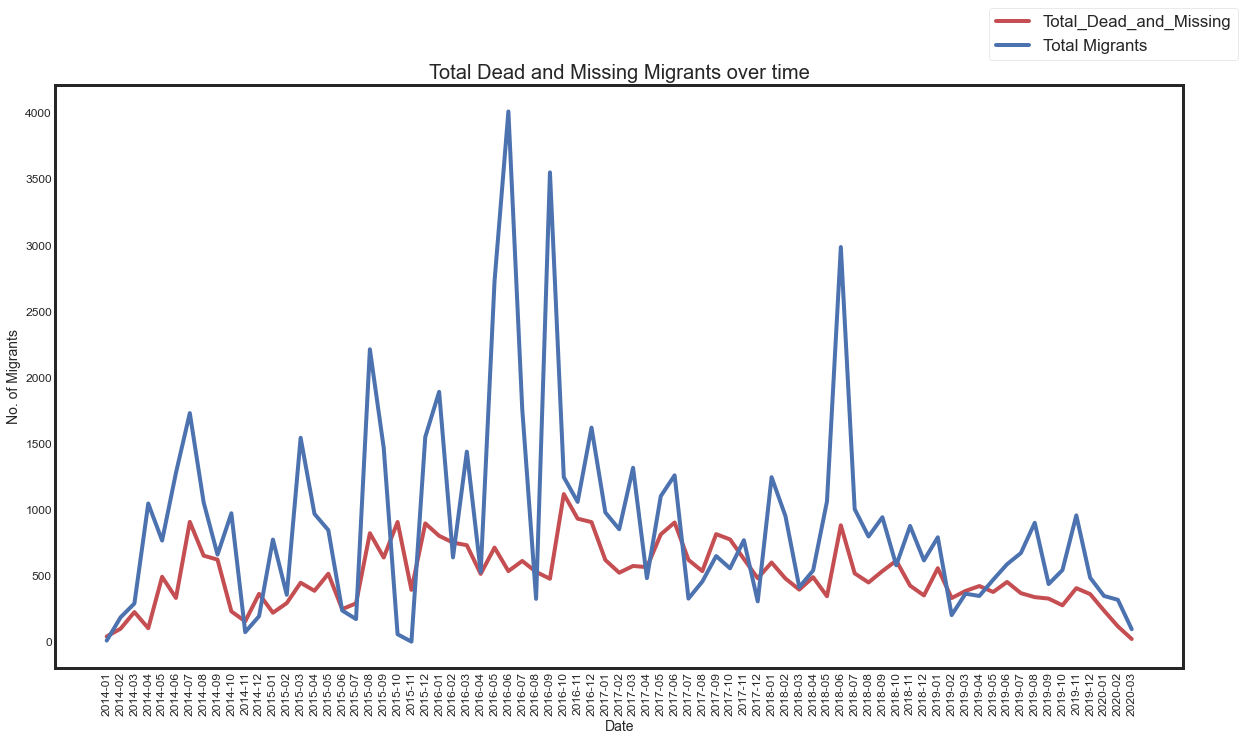

In [46]:
fig,ax =plt.subplots(figsize=(18,10))
ax = sns.lineplot(x="Reported_Month", y="Total_Dead_and_Missing", data=df_temp, color="r").set_title('Total Dead and Missing Migrants over time');
plt.xticks(rotation='vertical')

ax2 = sns.lineplot(x="Reported_Month", y="Total Migrants", data=df_temp, color="b")

ax.figure.legend(['Total_Dead_and_Missing','Total Migrants'],fontsize='large')

plt.xlabel('Date')
plt.ylabel('No. of Migrants')

It appears that the increase of the number of dead and missing was in mid 2018 then dropped by the end of that year. whilst the higest increase was in October 2016 and the lowest number of migrants was in Novemeber 2015

In this step we will standrised our dataset in order to use it for our prediction models. 


**Predicting number of Dead Migrants** 

This time we will use the data frame that we saved earlier during data visualisation part .

**6 Normalization**

Reading data in PySpark Dataframe



In [57]:
#Reading data in PySpark Dataframe
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('MissingMigrantsWithLatLong.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Web_ID: integer (nullable = true)
 |-- Region_of_Incident: string (nullable = true)
 |-- Reported_Date: string (nullable = true)
 |-- Reported_Year: integer (nullable = true)
 |-- Reported_Month: string (nullable = true)
 |-- Number_Dead: integer (nullable = true)
 |-- Minimum_Estimated_Number_of_Missing: integer (nullable = true)
 |-- Total_Dead_and_Missing: integer (nullable = true)
 |-- Number_of_Survivors: integer (nullable = true)
 |-- Number_of_Females: integer (nullable = true)
 |-- Number_of_Males: integer (nullable = true)
 |-- Number_of_Children: integer (nullable = true)
 |-- Cause_of_Death: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Information_Source: string (nullable = true)
 |-- Migration_Route: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- UNSD_Geographical_Grouping: string (nullable = true)
 |-- Source_Quality: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = tr

Visualizing top 5 rows

In [58]:
#Visualizing top 5 rows
pd.DataFrame(df.take(5), columns=df.columns).transpose()

0  \
Web_ID                                                            52932   
Region_of_Incident                                       Southeast Asia   
Reported_Date                                                 14-Mar-20   
Reported_Year                                                      2020   
Reported_Month                                                      Mar   
Number_Dead                                                           2   
Minimum_Estimated_Number_of_Missing                                   0   
Total_Dead_and_Missing                                                2   
Number_of_Survivors                                                   5   
Number_of_Females                                                     2   
Number_of_Males                                                       0   
Number_of_Children                                                    0   
Cause_of_Death                                         Vehicle Accident   
Location_Description                 Nikhom Phatthana, Rayong, Thailand   
Information_Source                                         Bangkok Post   
Migration_Route                                                           
URL                                              https://bit.ly/3aYbyfW   
UNSD_Geographical_Grouping                           South-eastern Asia   
Source_Quality                                                        1   
lat                                                          12.8299114   
long                                                        101.2043333   

                                                                     1  \
Web_ID                                                           52931   
Region_of_Incident                                       Mediterranean   
Reported_Date                                                12-Mar-20   
Reported_Year                                                     2020   
Reported_Month                                                     Mar   
Number_Dead                                                          3   
Minimum_Estimated_Number_of_Missing                                  5   
Total_Dead_and_Missing                                               8   
Number_of_Survivors                                                 39   
Number_of_Females                                                    2   
Number_of_Males                                                      0   
Number_of_Children                                                   1   
Cause_of_Death                                                Drowning   
Location_Description                 Off the coast of Larache, Morocco   
Information_Source                                 Caminando Fronteras   
Migration_Route                                  Western Mediterranean   
URL                                           https://archive.ph/gB4Vs   
UNSD_Geographical_Grouping                               Uncategorized   
Source_Quality                                                       4   
lat                                                        35.18986044   
long                                                      -6.173145607   

                                                                                   2  \
Web_ID                                                                         52924   
Region_of_Incident                                                  US-Mexico Border   
Reported_Date                                                              10-Mar-20   
Reported_Year                                                                   2020   
Reported_Month                                                                   Mar   
Number_Dead                                                                        1   
Minimum_Estimated_Number_of_Missing                                                0   
Total_Dead_and_Missing                                                             1  

Displaying each column's stats



In [59]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

0                    1  \
summary                              count                 mean   
Web_ID                                4226    46401.81779460483   
Reported_Year                         4226    2017.926407950781   
Number_Dead                           4226   2.3246568859441554   
Minimum_Estimated_Number_of_Missing   4226    1.539753904401325   
Total_Dead_and_Missing                4226   3.8644107903454805   
Number_of_Survivors                   4226    5.170137245622338   
Number_of_Females                     4226    0.426171320397539   
Number_of_Males                       4226   1.0915759583530524   
Number_of_Children                    4226  0.24136299100804542   

                                                      2      3      4  
summary                                          stddev    min    max  
Web_ID                                6599.442821518081  30158  52932  
Reported_Year                        0.8623777330645601   2016   2020  
Number_Dead                           4.804843974770655      0     84  
Minimum_Estimated_Number_of_Missing   9.932408508496781      0    172  
Total_Dead_and_Missing               11.314621711277756      0    176  
Number_of_Survivors                  29.118759773155205      0    937  
Number_of_Females                    1.5476239051992404      0     30  
Number_of_Males                        3.33401192673358      0     95  
Number_of_Children                   0.9960644152516456      0     29

 Grouping Number of Males VS Number of Females againse each year
 More males than females each year, but the most amount of both is in year 2018

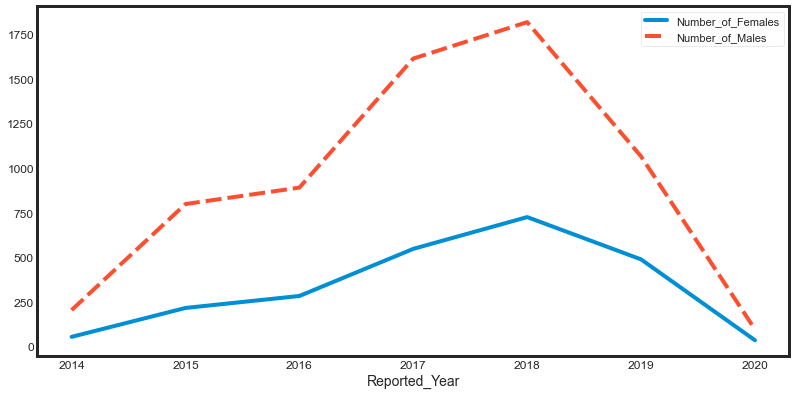

In [60]:
#Grouping Number of Males VS Number of Females againse each year
#More males than females each year, but the most amount of both is in year 2018
df = missingMigrants.groupby('Reported_Year').agg({'Number_of_Females':'sum','Number_of_Males':'sum'}).astype(int)
plt.figure(figsize=(12,6))
sns.lineplot(data=df)

Grouping Number of Dead migrants VS Number of Survivors against each year.Most Survived migrants than dead in each year Mostly dead in 2015, and mostly survived in 2016

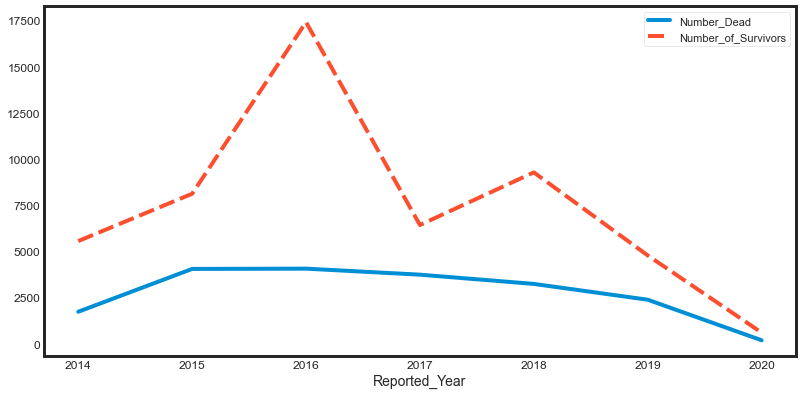

In [61]:
#Grouping Number of Dead migrants VS Number of Survivors against each year
#Most Survived migrants than dead in each year
#Mostly dead in 2015, and mostly survived in 2016
df = missingMigrants.groupby('Reported_Year').agg({'Number_Dead':'sum','Number_of_Survivors':'sum'}).astype(int)
# x = dataframe['Reported Month'].value_counts().index.values
# y = dataframe['Reported Month'].value_counts().values
plt.figure(figsize=(12,6))
sns.lineplot(data=df)

Reading data in PySpark Dataframe



In [62]:
#Reading data in PySpark Dataframe

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('MissingMigrantsWithLatLong.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Web_ID: integer (nullable = true)
 |-- Region_of_Incident: string (nullable = true)
 |-- Reported_Date: string (nullable = true)
 |-- Reported_Year: integer (nullable = true)
 |-- Reported_Month: string (nullable = true)
 |-- Number_Dead: integer (nullable = true)
 |-- Minimum_Estimated_Number_of_Missing: integer (nullable = true)
 |-- Total_Dead_and_Missing: integer (nullable = true)
 |-- Number_of_Survivors: integer (nullable = true)
 |-- Number_of_Females: integer (nullable = true)
 |-- Number_of_Males: integer (nullable = true)
 |-- Number_of_Children: integer (nullable = true)
 |-- Cause_of_Death: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Information_Source: string (nullable = true)
 |-- Migration_Route: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- UNSD_Geographical_Grouping: string (nullable = true)
 |-- Source_Quality: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = tr



Selcecting the required columns of dataset in prediction



In [63]:
#Selcecting the required columns of dataset in prediction
df = df.select('Web_ID', 'Region_of_Incident', 'Reported_Date', 'Reported_Year', 'Reported_Month', 'Number_Dead', 'Minimum_Estimated_Number_of_Missing',
'Total_Dead_and_Missing', 'Number_of_Survivors', 'Number_of_Females', 'Number_of_Males', 'Number_of_Children', 'Cause_of_Death',
'Location_Description', 'Information_Source', 'Migration_Route', 'URL', 'UNSD_Geographical_Grouping', 'Source_Quality', 'lat', 'long')
cols = df.columns
df.printSchema()

root
 |-- Web_ID: integer (nullable = true)
 |-- Region_of_Incident: string (nullable = true)
 |-- Reported_Date: string (nullable = true)
 |-- Reported_Year: integer (nullable = true)
 |-- Reported_Month: string (nullable = true)
 |-- Number_Dead: integer (nullable = true)
 |-- Minimum_Estimated_Number_of_Missing: integer (nullable = true)
 |-- Total_Dead_and_Missing: integer (nullable = true)
 |-- Number_of_Survivors: integer (nullable = true)
 |-- Number_of_Females: integer (nullable = true)
 |-- Number_of_Males: integer (nullable = true)
 |-- Number_of_Children: integer (nullable = true)
 |-- Cause_of_Death: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Information_Source: string (nullable = true)
 |-- Migration_Route: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- UNSD_Geographical_Grouping: string (nullable = true)
 |-- Source_Quality: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = tr

Setting up the features ( features are the all the columns from except"Number_Dead", the labels is the "Number_Dead" column that contains the number of dead migrants.)
We firsly:

* Selecting all the String type columns from selected columns in above cell
* Converting string columns to Some integer representation for using in Machine Learning model
* Selecting Numerical columns
* Combining String and Numerical columns together and call them features





In [64]:
#Setting up the features ( features are the all the columns from except"Number_Dead", the labels is the "Number_Dead" column that contains the number of dead migrants.)

#Selecting all the String type columns
categoricalColumns = ['Region_of_Incident', 'Reported_Date', 'Reported_Month',  'Cause_of_Death', 
                      'Location_Description', 'Information_Source', 'Migration_Route', 'URL', 'UNSD_Geographical_Grouping', 'Source_Quality', 'lat', 'long']
stages = []

#Converting string columns to Some integer representation for using in Machine Learning model
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols= [stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

#Selecting Numerical columns
numericCols = ['Web_ID','Reported_Year', 'Minimum_Estimated_Number_of_Missing', 'Total_Dead_and_Missing', 'Number_of_Survivors', 'Number_of_Females', 
               'Number_of_Males', 'Number_of_Children']
#Combining String and Numerical columns together and call them features
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")


Setting up Data Pipeline for Machine Learning Model



In [65]:
#Setting up Data Pipeline for Machine Learning Model

from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

Saving label and feature columns in dataset

In [66]:
#Saving label and feature columns in dataset
data_2 = assembler.transform(df)

In [67]:
data_2.show()

+------+------------------+-------------+-------------+--------------+-----------+-----------------------------------+----------------------+-------------------+-----------------+---------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------+-----------+------------+-----------------------+--------------------------+------------------+---------------------+-------------------+----------------------+-------------------+----------------------+-------------------------+----------------------------+-----------------------+--------------------------+--------------------+-----------------------+--------+-------------------+-------------------------------+----------------------------------+-------------------+----------------------+--------+-------------------+---------+-------------------+--------------------+
|Web_ID|Region_of_Incident|Reported_Date|Reported_Year|Reported_M

Spliting 70% data for training and 30% for testing


In [68]:
train, test = data_2.randomSplit([0.7, 0.3],seed=2018)

Passing features and labels in Linear Regression

In [69]:
algo = LinearRegression(featuresCol="features", labelCol="Number_Dead")

In this step we are 

* Fitting model on training data

* Evaluating  model on testing data

* Printing evaluation measures


In statistics, the coefficient of determination, denoted R² or r² and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable.




In [70]:
model = algo.fit(train)
evaluation_summary = model.evaluate(test)
print("meanAbsoluteError at testing time: ", evaluation_summary.meanAbsoluteError)
print("rootMeanSquaredError at testing time: ", evaluation_summary.rootMeanSquaredError)
print("Coefficient of determination at testing time: ", evaluation_summary.r2) 


meanAbsoluteError at testing time:  2.1832020826624787
rootMeanSquaredError at testing time:  4.451053770459401
Coefficient of determination at testing time:  0.242903480496113


**7 Data analysis**

#Making predictions on testing data

#Displaying Actual Number of deads vs Made predictions

Below you need to compare "Prediction" (Model actually predicted) made by model and "Number_Dead" (actual ground truth, that is the real value the model should have been predicted)


In [71]:
predictions = model.transform(test)

predictions.select('prediction', 'Number_Dead', 'features').show(1200)



+--------------------+-----------+--------------------+
|          prediction|Number_Dead|            features|
+--------------------+-----------+--------------------+
|  -0.917506175843382|          1|(13316,[2,618,113...|
|  1.1377214401878177|          1|(13316,[0,273,113...|
|  1.2152465727112016|          1|(13316,[0,583,113...|
|  0.4816768019976969|          5|(13316,[2,230,113...|
|   2.425312751380565|          2|(13316,[7,230,113...|
|  0.7019413780603081|          1|(13316,[0,358,113...|
|  1.9296884214976728|          1|(13316,[0,818,113...|
| -0.5474399475773879|          1|(13316,[1,510,113...|
|   1.360628518738558|          1|(13316,[0,933,113...|
|    2.15516002915375|          1|(13316,[0,933,113...|
| -1.8818590136495743|         14|(13316,[2,947,113...|
|  -2.707878018157569|          3|(13316,[2,62,1130...|
| 0.49922020289776725|          1|(13316,[0,62,1130...|
|   24.53982016564611|          4|(13316,[2,32,1130...|
|  1.6075581433840256|          1|(13316,[2,32,1

Evaluating and displaying Root Mean Square error on testing data



In [72]:
lr_evaluator = RegressionEvaluator(
    labelCol="Number_Dead", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.45105


We are Selecting true labels and predicted labels to covert spark dataframe in Panda dataframe

Plotting Output of our model and ground truths i.e. "Prediction vs real"

We may see the difference between actual values(groud truths) and Model's predictions.



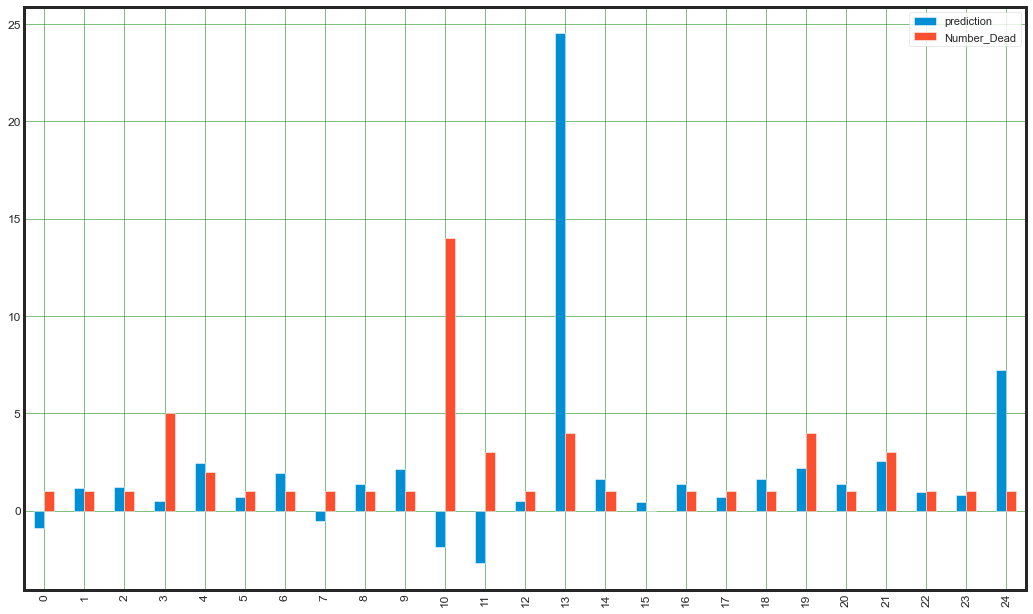

In [73]:
results_lr = predictions.select(['prediction', 'Number_Dead'])

pandas_df_lr = results_lr.select("*").toPandas()

df1_lr = pandas_df_lr.head(25)
df1_lr.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show() 


The result of linear regression model are not so impresssive so we will Passe features and labels to Decision tree 

model.

We will firstly:

* Fitting the model on training data


* Making predictions on testing data


* Evaluating predictions



In [74]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Number_Dead')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="Number_Dead", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.18627


Displaying Actual Number of deads vs Made predictions


In [75]:
dt_predictions.select('prediction', 'Number_Dead', 'features').show(2900)

+------------------+-----------+--------------------+
|        prediction|Number_Dead|            features|
+------------------+-----------+--------------------+
|               1.0|          1|(13316,[2,618,113...|
|               1.0|          1|(13316,[0,273,113...|
|               1.0|          1|(13316,[0,583,113...|
|5.3578947368421055|          5|(13316,[2,230,113...|
|               2.0|          2|(13316,[7,230,113...|
|               1.0|          1|(13316,[0,358,113...|
|               1.0|          1|(13316,[0,818,113...|
|               1.0|          1|(13316,[1,510,113...|
|               1.0|          1|(13316,[0,933,113...|
|               1.0|          1|(13316,[0,933,113...|
| 14.31578947368421|         14|(13316,[2,947,113...|
| 2.973821989528796|          3|(13316,[2,62,1130...|
|               1.0|          1|(13316,[0,62,1130...|
| 4.728155339805825|          4|(13316,[2,32,1130...|
|               1.0|          1|(13316,[2,32,1130...|
|0.7543859649122807|        

We will covert spark dataframe in Panda dataframe and then plot the output of our model and ground truths i.e. 

"Prediction vs real"

We can see, this time, the difference is very low. That means Models is very well trained





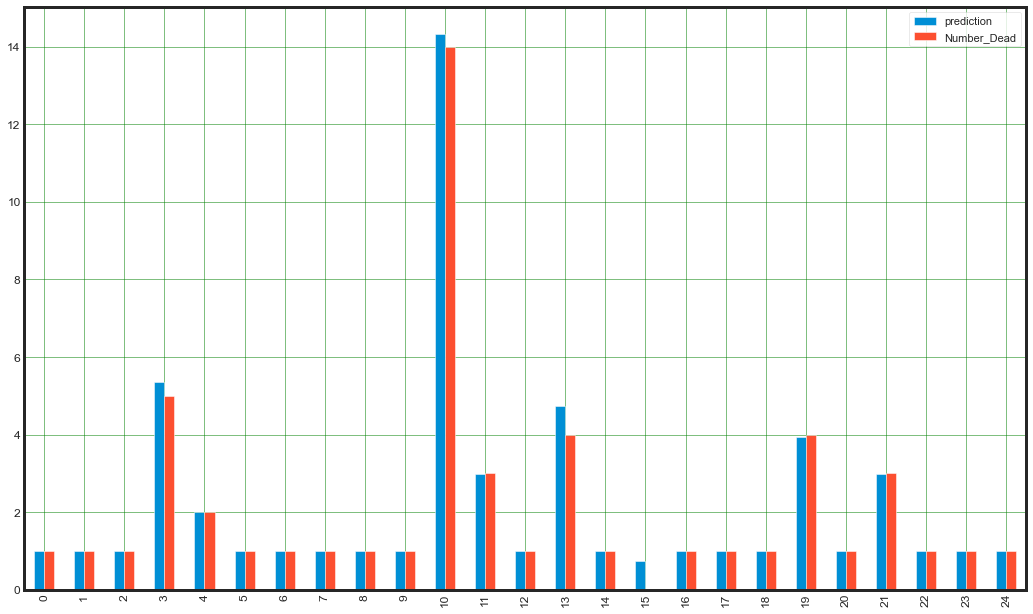

In [76]:
results = dt_predictions.select(['prediction', 'Number_Dead'])

pandas_df = results.select("*").toPandas()

df1 = pandas_df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()      

To check our model further we will pass the labels and features to Gradient-Boosted tree regressor

then we will fit the model with training data and make predictions on testing data

and finally display prediction results.





In [77]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Number_Dead', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'Number_Dead', 'features').show(2000)

+--------------------+-----------+--------------------+
|          prediction|Number_Dead|            features|
+--------------------+-----------+--------------------+
|  0.9923695563626487|          1|(13316,[2,618,113...|
|  0.9923695563626487|          1|(13316,[0,273,113...|
|  0.9923695563626487|          1|(13316,[0,583,113...|
|   5.350264293204754|          5|(13316,[2,230,113...|
|   1.992369556362649|          2|(13316,[7,230,113...|
|  0.9923695563626487|          1|(13316,[0,358,113...|
|  0.9923695563626487|          1|(13316,[0,818,113...|
|  0.9923695563626487|          1|(13316,[1,510,113...|
|  0.9923695563626487|          1|(13316,[0,933,113...|
|  0.9923695563626487|          1|(13316,[0,933,113...|
|  14.308159030046857|         14|(13316,[2,947,113...|
|   2.966191545891445|          3|(13316,[2,62,1130...|
|  0.9923695563626487|          1|(13316,[0,62,1130...|
|   4.823699723200153|          4|(13316,[2,32,1130...|
|  0.9923695563626487|          1|(13316,[2,32,1

 We will then evaluate the model on made predictions using Root Mean Squared Error (RMSE) to test the preformance of our model



In [78]:
gbt_evaluator = RegressionEvaluator(
    labelCol="Number_Dead", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.18498


To visualise our result we will conduct the same methods as before 

* select true labels and predicted labels

* covert spark dataframe in Panda dataframe

* Plotting Output of our model and Ground truth i.e. "Prediction vs real"


We may see, again results for this model are also well trained. therefore  We may see that Decision Tree Regressor performed Best on our data, with very much accurate predictions, GBT is also accurate while Linear regression didn't perform well.

So DT and GBT are the fine choices.

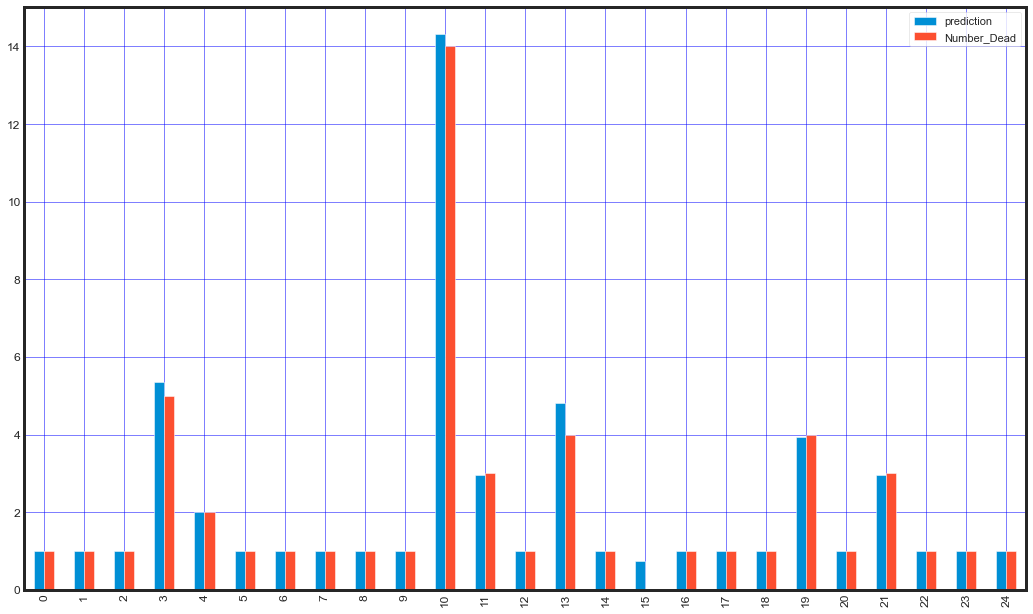

In [79]:
results_gbt = gbt_predictions.select(['prediction', 'Number_Dead'])

pandas_df_gbt = results_gbt.select("*").toPandas()

df1_gbt = pandas_df_gbt.head(25)
df1_gbt.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='red')
plt.show() 

**3. Predicting Most Dangerous Migration Routes**

This dataframe has been aquired by using the following SQL querry to extracting unique values in our dataset{ missingMigrants} {Migration_Route'].unique() to give us all the unique causes of deaths of that particular migration route


rslt_df = missingMigrants[missingMigrants['Migration_Route'] == 'putHereRouteNameOneByOne']
print('\nResult dataframe :\n', rslt_df)
rslt_df.Cause_of_Death.unique()


In [80]:
missingMigrants = pd.read_csv('DangeRoutesFinal.csv')
missingMigrants.shape

(3368, 3)

In [81]:
missingMigrants.head(500)

Number_Dead        Migration_Route Danger_Level_of_MigrationRoute
0              3  Western Mediterranean                 Most Dangerous
1              1  Eastern Mediterranean                 Most Dangerous
2              1        Western African                 More Dangerous
3              1  Central America to US                 Most Dangerous
4              1  Western Mediterranean                 Most Dangerous
..           ...                    ...                            ...
495            1  Western Mediterranean                 Most Dangerous
496            1  Central America to US                 Most Dangerous
497            1  Central America to US                 Most Dangerous
498            1  Central America to US                 Most Dangerous
499            1  Central America to US                 Most Dangerous

[500 rows x 3 columns]

Checking missing values in the given column

In [82]:
missingMigrants['Migration_Route'].unique()

array(['Western Mediterranean', 'Eastern Mediterranean',
       'Western African', 'Central America to US', 'Western Balkans',
       'Central Mediterranean', 'Horn Africa to Yemen', 'Italy to France',
       'Calais to United Kingdom', 'Darien Gap',
       'Dominican Republic to Puerto Rico', 'Malaysia to Indonesia',
       'From Haiti to Dajabon, Dominican Republic',
       'Caribbean to Central America', 'Venezuela to Curaçao'],
      dtype=object)

Reading Dataset in dataframe

Displaying Shape of Frame

In [83]:
missingMigrants = pd.read_csv('MissingMigrants-Global-2020-03-21T11-18-26 .csv')
missingMigrants.shape       

(6472, 20)


Plotting Range of all Numeric Columns in dataset except Web_ID



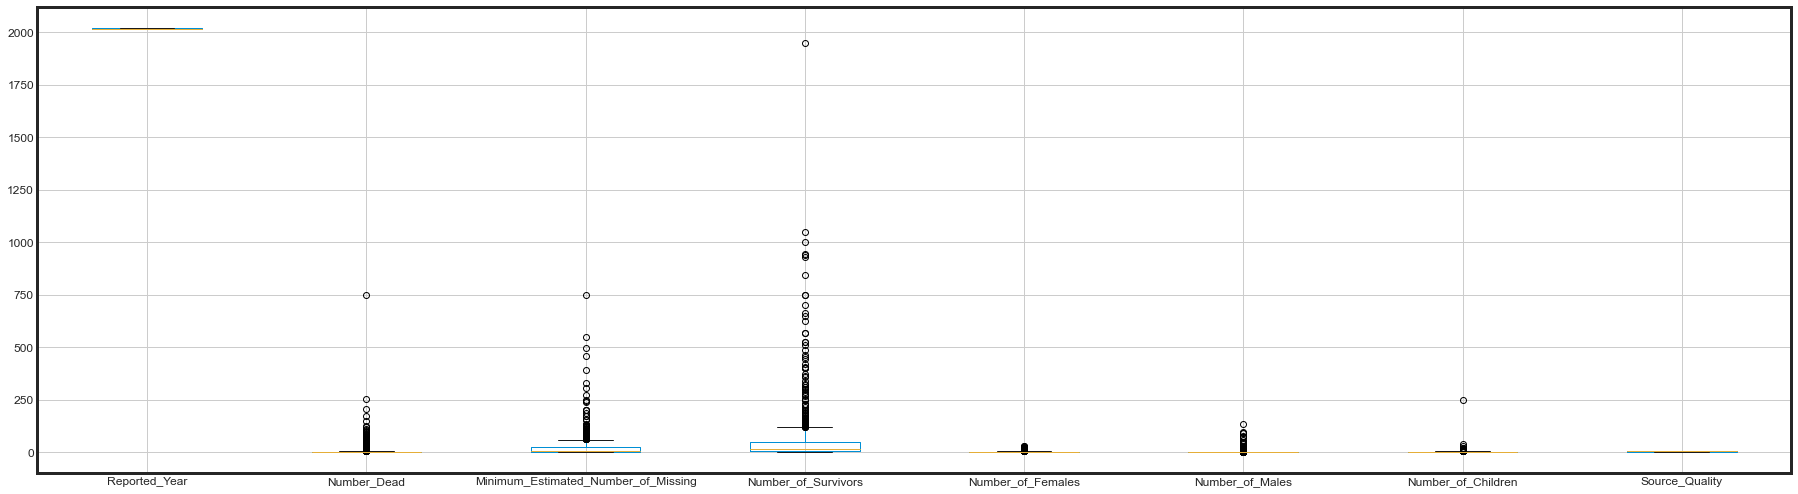

In [84]:
missingMigrants.loc[:, missingMigrants.columns != 'Web_ID'].boxplot(figsize=(28,8))

All attributes versus all attributes. The diagonal where each attribute would be plotted against itself shows the Kernel Density Estimation of the attribute instead


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a222cd310>,
      dtype=object)

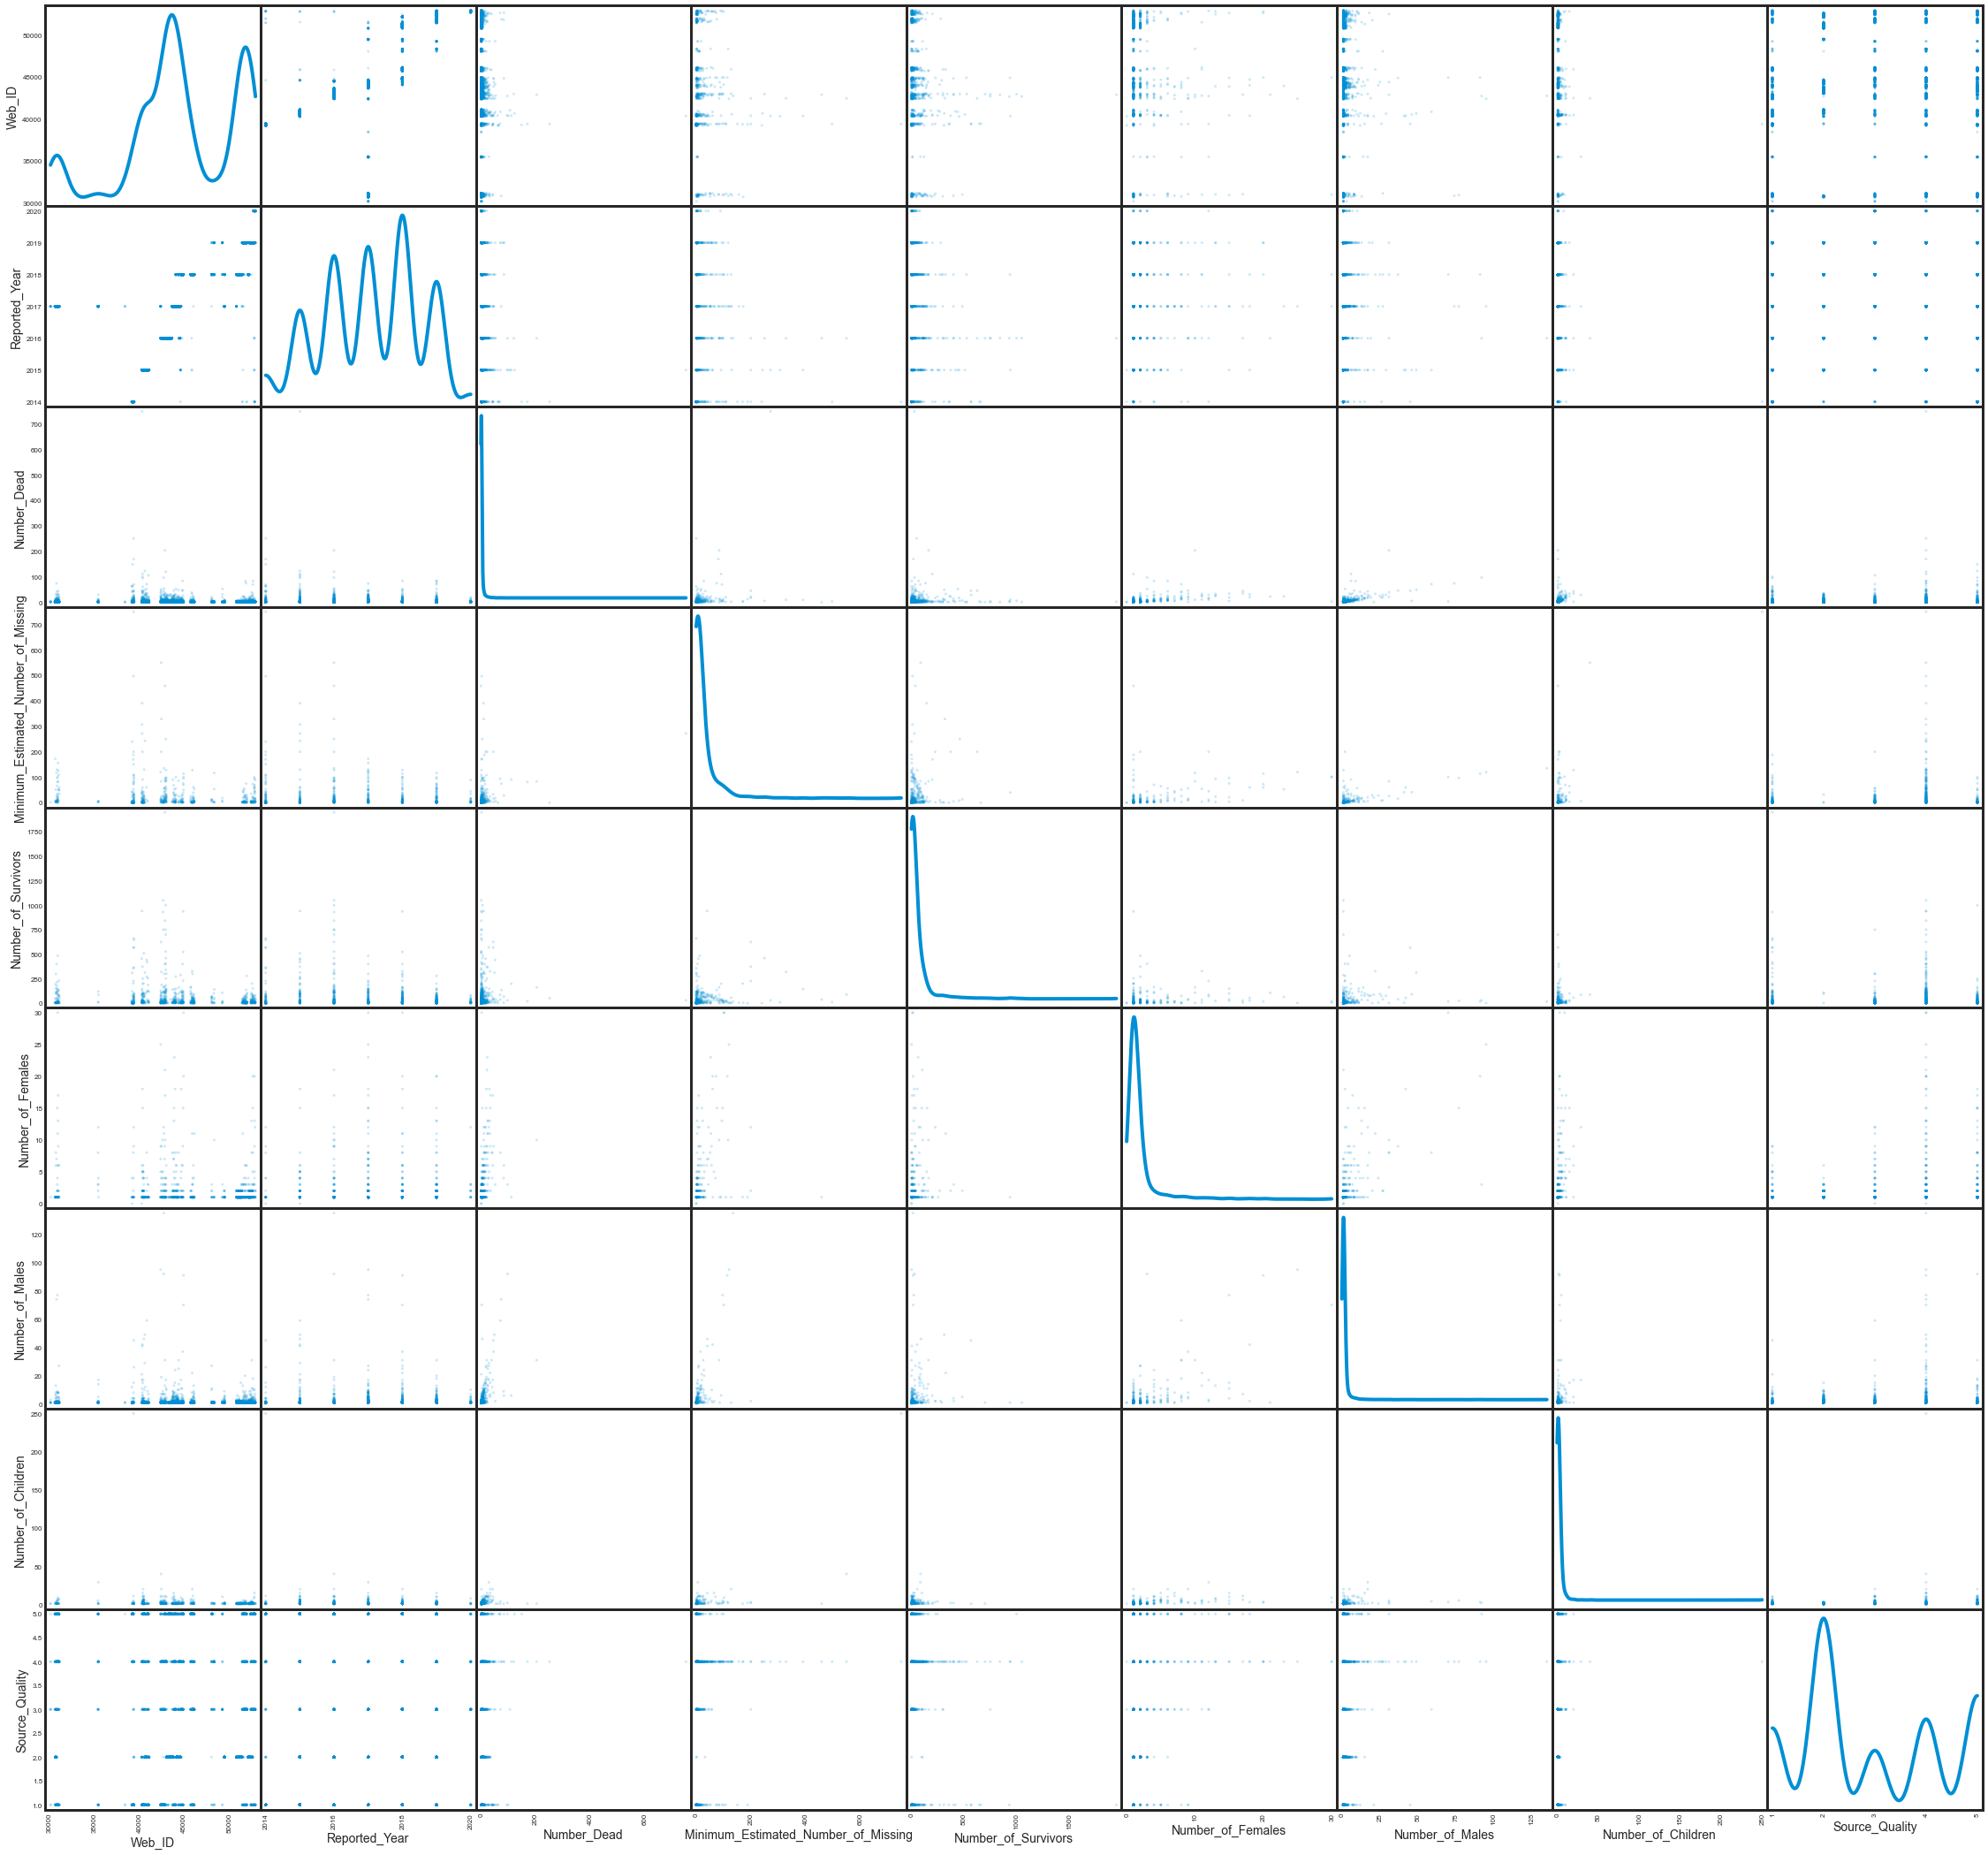

In [85]:
from pandas.plotting import scatter_matrix
scatter_matrix(missingMigrants, alpha=0.2, figsize=(35, 35), diagonal='kde')




Finds max Number of Dead migrants reported which is 750.0





In [86]:
missingMigrants.agg({'Number_Dead': ['max']})

Number_Dead
max        750.0

Finds max Number of Dead migrants reported. Central Mediterranean route has the highest number of death reported 




In [87]:
missingMigrants[missingMigrants.Number_Dead == 750].Migration_Route

6106    Central Mediterranean
Name: Migration_Route, dtype: object

Here are the migrqation routes with the most number of deaths of > 100



In [88]:
missingMigrants[missingMigrants.Number_Dead > 100].Migration_Route

4496    Central Mediterranean
4666    Central Mediterranean
5410    Central America to US
5870    Central Mediterranean
6067                      NaN
6106    Central Mediterranean
6262    Central America to US
6298    Central Mediterranean
6429                      NaN
Name: Migration_Route, dtype: object

Initiating Sark session and reading dataset in spark dataframe for applying ML models



In [89]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('DangeRoutesFinal.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Number_Dead: integer (nullable = true)
 |-- Migration_Route: string (nullable = true)
 |-- Danger_Level_of_MigrationRoute: string (nullable = true)



Visualizing top 5 rows

In [90]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

0                      1  \
Number_Dead                                         3                      1   
Migration_Route                 Western Mediterranean  Eastern Mediterranean   
Danger_Level_of_MigrationRoute         Most Dangerous         Most Dangerous   

                                              2                      3  \
Number_Dead                                   1                      1   
Migration_Route                 Western African  Central America to US   
Danger_Level_of_MigrationRoute   More Dangerous         Most Dangerous   

                                                    4  
Number_Dead                                         1  
Migration_Route                 Western Mediterranean  
Danger_Level_of_MigrationRoute         Most Dangerous

In [91]:
df.show(10)

+-----------+--------------------+------------------------------+
|Number_Dead|     Migration_Route|Danger_Level_of_MigrationRoute|
+-----------+--------------------+------------------------------+
|          3|Western Mediterra...|                Most Dangerous|
|          1|Eastern Mediterra...|                Most Dangerous|
|          1|     Western African|                More Dangerous|
|          1|Central America t...|                Most Dangerous|
|          1|Western Mediterra...|                Most Dangerous|
|          1|Central America t...|                Most Dangerous|
|          1|Central America t...|                Most Dangerous|
|          0|     Western African|                More Dangerous|
|          1|     Western Balkans|                More Dangerous|
|          1|Western Mediterra...|                Most Dangerous|
+-----------+--------------------+------------------------------+
only showing top 10 rows



So back to our second research question 


**What are the most dangerous routes that migrant use?**


We are going to use **Logistic Regression** model to predict 

We will select the column involved in training



In [92]:

df = df.select('Number_Dead', 'Migration_Route', 'Danger_Level_of_MigrationRoute')
cols = df.columns
df.printSchema()

root
 |-- Number_Dead: integer (nullable = true)
 |-- Migration_Route: string (nullable = true)
 |-- Danger_Level_of_MigrationRoute: string (nullable = true)



How many classes of Danger_Level_of_MigrationRoute


In [93]:
df.select('Danger_Level_of_MigrationRoute').distinct().count()

3

Names of Distinct danger Levels



In [94]:
df.select('Danger_Level_of_MigrationRoute').distinct().show()

+------------------------------+
|Danger_Level_of_MigrationRoute|
+------------------------------+
|                More Dangerous|
|            Slightly Dangerous|
|                Most Dangerous|
+------------------------------+



To prepare our model we will firstly select string columns and convert strings into numerical representation.Then

we will select target column and numerical columns and finally we will combiane String and numerical columns 

together and call them features






In [95]:
categoricalColumns = ['Migration_Route']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols= [stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Danger_Level_of_MigrationRoute', outputCol = 'label')  
stages += [label_stringIdx]

numericCols = ['Number_Dead']


assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Setting up Data Pipeline for Machine Learning Model

Save label and feature columns in dataset



In [96]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Number_Dead: integer (nullable = true)
 |-- Migration_Route: string (nullable = true)
 |-- Danger_Level_of_MigrationRoute: string (nullable = true)




Split 70% data for training and 30% for testing

In [97]:
train, test = df.randomSplit([0.7, 0.3])

Passing features and labels in Logistic Regression Model and fitting the model on training data





In [98]:

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=600)
lrModel = lr.fit(train)


Summarize the model over the training set and Printing models accuracy





In [99]:
#Summarize the model over the training set
trainingSummary = lrModel.summary
print('Accuracy: ' + str((trainingSummary.accuracy)*100), '%')

Accuracy: 100.0 %


Evaluation Measures

In [100]:

print("Accuracy: ", (trainingSummary.accuracy)*100, '%')
print("Precision: ", trainingSummary.weightedPrecision)
print("Recall: ", trainingSummary.weightedRecall)
print("TruePositiveRate: ", trainingSummary.weightedTruePositiveRate)
print("FalsePositiveRate: ", trainingSummary.weightedFalsePositiveRate)

Accuracy:  100.0 %
Precision:  1.0
Recall:  1.0
TruePositiveRate:  1.0
FalsePositiveRate:  0.0


Now we will make prediction on test set.

Below you need to see "label" column and "prediction" column to predict
Whats happening below is that label column came from column "Danger_Level_of_MigrationRoute", Why? because pyspark assigned distinct numbers to distinct danger levels for simplicity
it assigned:

* 0 for Most Dangerous

* 1 for More dangerous

* 2 for Slightly Dangerous

In [101]:

predictions = lrModel.transform(train)
predictions.select('Number_Dead', 'Migration_Route', 'Danger_Level_of_MigrationRoute', 'label', 'prediction', 'probability').show(2720)


+-----------+--------------------+------------------------------+-----+----------+--------------------+
|Number_Dead|     Migration_Route|Danger_Level_of_MigrationRoute|label|prediction|         probability|
+-----------+--------------------+------------------------------+-----+----------+--------------------+
|          0|Central America t...|                Most Dangerous|  0.0|       0.0|[0.99999999918980...|
|          0|Central America t...|                Most Dangerous|  0.0|       0.0|[0.99999999918980...|
|          0|Central America t...|                Most Dangerous|  0.0|       0.0|[0.99999999918980...|
|          0|Central America t...|                Most Dangerous|  0.0|       0.0|[0.99999999918980...|
|          0|Central America t...|                Most Dangerous|  0.0|       0.0|[0.99999999918980...|
|          0|Central America t...|                Most Dangerous|  0.0|       0.0|[0.99999999918980...|
|          0|Central America t...|                Most Dangerous

we will finally evluate our our Logistic Regression model.


In [102]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', (evaluator.evaluate(predictions))*100)

Test Area Under ROC 100.0


Now our last research question is

**Predicting Causes of Deaths per  Region?**

The dataframe we will use for this analysis has been manualy extracted from our main dataest 



Reading dataset



In [103]:
missingMigrants = pd.read_csv('DeathCausesPerRegionFinal.csv')
missingMigrants.shape

(299, 3)

In [104]:
missingMigrants.head(5)

Region_of_Incident                                   Cause_of_Death  \
0     Southeast Asia                                 Vehicle Accident   
1      Mediterranean                                         Drowning   
2   US-Mexico Border  Accident (fell down while climbing border wall)   
3             Europe                                Presumed drowning   
4   US-Mexico Border                                Presumed drowning   

                              CausesOfDeathPerRegion  
0  Vehicle Accident,Drowning,Killed by landmine b...  
1  Drowning,Shot,Hypothermia,Fall from truck,Star...  
2  Accident(fell down while climbing border wall)...  
3  Shot,Suffocation,Vehicle accident,Exposure,Unk...  
4  Accident(fell down while climbing border wall)...

Checking all unique region of incidents




In [105]:
missingMigrants['Region_of_Incident'].unique()

array(['Southeast Asia', 'Mediterranean', 'US-Mexico Border', 'Europe',
       'North Africa', 'South America', 'Central America', 'Middle East',
       'Sub-Saharan Africa', 'Caribbean', 'South Asia', 'East Asia',
       'Horn of Africa'], dtype=object)

Displying causes of deaths per region



In [106]:
grp = missingMigrants.groupby(['Region_of_Incident', 'Cause_of_Death'])
grp.first()

CausesOfDeathPerRegion
Region_of_Incident Cause_of_Death                                                                             
Caribbean          Drowning                                  Drowning,Vehicle Accident,Shot,Dehydration,Hit...
                   Presumed drowning                         Drowning,Vehicle Accident,Shot,Dehydration,Hit...
Central America    Drowning                                  Vehicle Accident,Fell from train,Hit by train,...
                   Fall from train                           Vehicle Accident,Fell from train,Hit by train,...
                   Fell from train                           Vehicle Accident,Fell from train,Hit by train,...
...                                                                                                        ...
US-Mexico Border   Sickness and lack of access to medicines  Accident(fell down while climbing border wall)...
                   Suicide                                   Accident(fell down while climbing border wall)...
                   Unknown                                   Accident(fell down while climbing border wall)...
                   Unknown (skeletal remains)                Accident(fell down while climbing border wall)...
                   Vehicle Accident                          Accident(fell down while climbing border wall)...

[94 rows x 1 columns]

In [107]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('DeathCausesPerRegionFinal.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Region_of_Incident: string (nullable = true)
 |-- Cause_of_Death: string (nullable = true)
 |-- CausesOfDeathPerRegion: string (nullable = true)



Visualizing top 5 rows



In [108]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

0  \
Region_of_Incident                                         Southeast Asia   
Cause_of_Death                                           Vehicle Accident   
CausesOfDeathPerRegion  Vehicle Accident,Drowning,Killed by landmine b...   

                                                                        1  \
Region_of_Incident                                          Mediterranean   
Cause_of_Death                                                   Drowning   
CausesOfDeathPerRegion  Drowning,Shot,Hypothermia,Fall from truck,Star...   

                                                                        2  \
Region_of_Incident                                       US-Mexico Border   
Cause_of_Death            Accident (fell down while climbing border wall)   
CausesOfDeathPerRegion  Accident(fell down while climbing border wall)...   

                                                                        3  \
Region_of_Incident                                                 Europe   
Cause_of_Death                                          Presumed drowning   
CausesOfDeathPerRegion  Shot,Suffocation,Vehicle accident,Exposure,Unk...   

                                                                        4  
Region_of_Incident                                       US-Mexico Border  
Cause_of_Death                                          Presumed drowning  
CausesOfDeathPerRegion  Accident(fell down while climbing border wall)...

We will select this column to involved in model training Region_of_Incident ,Cause_of_Death , CausesOfDeathPerRegion

In [109]:

df = df.select('Region_of_Incident', 'Cause_of_Death', 'CausesOfDeathPerRegion')
cols = df.columns
df.printSchema()

root
 |-- Region_of_Incident: string (nullable = true)
 |-- Cause_of_Death: string (nullable = true)
 |-- CausesOfDeathPerRegion: string (nullable = true)



we will select string columns Region_of_Incident and Cause_of_Death

our target columns is CausesOfDeathPerRegion

 we will then combaine string and numerical columns together and call them features


In [110]:

categoricalColumns = ['Region_of_Incident', 'Cause_of_Death']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols= [stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'CausesOfDeathPerRegion', outputCol = 'label')   #Here it assigns a unique number to each unique value in CausesOfDeathPerRegion column and creates a label column
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages += [assembler]


* Setting up Data Pipeline for Machine Learning Model
* Saving label and feature columns in dataset




In [111]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Region_of_Incident: string (nullable = true)
 |-- Cause_of_Death: string (nullable = true)
 |-- CausesOfDeathPerRegion: string (nullable = true)



Spliting 70% data for training and 30% for testing



In [112]:
train, test = df.randomSplit([0.7, 0.3])

Passing features and labels in Logistic Regression Model and fitting the model on training data





In [113]:


lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=600)


lrModel = lr.fit(train)

Summarize the model over the training set



In [114]:
trainingSummary = lrModel.summary
print('Accuracy: ' + str((trainingSummary.accuracy)*100), '%')

Accuracy: 100.0 %


Evaluation Measures



In [115]:

print("Accuracy: ", (trainingSummary.accuracy)*100, '%')
print("Precision: ", trainingSummary.weightedPrecision)
print("Recall: ", trainingSummary.weightedRecall)
print("TruePositiveRate: ", trainingSummary.weightedTruePositiveRate)
print("FalsePositiveRate: ", trainingSummary.weightedFalsePositiveRate)

Accuracy:  100.0 %
Precision:  1.0
Recall:  1.0
TruePositiveRate:  1.0
FalsePositiveRate:  0.0


Now we will make predictions on the test set.

To view the results we need to compare label and prediction columns
label column came from column "CausesOfDeathPerRegion", Pyspark assigned a distinct number in label column to a distinct value in in CausesOfDeathPerRegion column



In [116]:

predictions = lrModel.transform(train)
predictions.select('Cause_of_Death', 'Region_of_Incident', 'CausesOfDeathPerRegion', 'label', 'prediction', 'probability').show(2720)



+--------------------+------------------+----------------------+-----+----------+--------------------+
|      Cause_of_Death|Region_of_Incident|CausesOfDeathPerRegion|label|prediction|         probability|
+--------------------+------------------+----------------------+-----+----------+--------------------+
|        Hyperthermia|  US-Mexico Border|  Accident(fell dow...|  0.0|       0.0|[0.99999999928034...|
|            Drowning|  US-Mexico Border|  Accident(fell dow...|  0.0|       0.0|[0.99999999862595...|
|            Drowning|  US-Mexico Border|  Accident(fell dow...|  0.0|       0.0|[0.99999999862595...|
|            Drowning|  US-Mexico Border|  Accident(fell dow...|  0.0|       0.0|[0.99999999862595...|
|            Drowning|  US-Mexico Border|  Accident(fell dow...|  0.0|       0.0|[0.99999999862595...|
|            Drowning|  US-Mexico Border|  Accident(fell dow...|  0.0|       0.0|[0.99999999862595...|
|            Drowning|  US-Mexico Border|  Accident(fell dow...|  0.0|   

Finally we will evaluate our Logistic Regression model.

our model fit the test area under 99.99999999999997

In [117]:
evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', (evaluator.evaluate(predictions))*100)

Test Area Under ROC 100.0




**Time Series Analysis of Missing Migrants**

Time series analysis  methods is for analyzing time series data in order to extract meaningful statistics from Data. Time series forecasting is the use of a model fbprohet to predict future values based on previously observed values.
As our Data is time series, we have to forecaste/predict using time seroies forecasting package [fbprophet]

The dataframe we are using is a renamed copy of (MissingMigrantsWithLatLong.csv) dataframe that we used earlier. But as I am using use inputation function for this analysis i noticed it confilect with other analysis who used the same dataset.

In [118]:
df= pd.read_csv('Time Series Analysis of Missing Migrants.csv') 

**Data Cleaning**

Dealing With missing Values

In [119]:
def meanFFill_imputation(df):
    df.fillna(df.mean(), inplace=True)
    return df
df_meanffill= meanFFill_imputation(df)
df_meanffill.head()

Web_ID Region_of_Incident Reported_Date  Reported_Year Reported_Month  \
0   52932     Southeast Asia     14-Mar-20           2020            Mar   
1   52931      Mediterranean     12-Mar-20           2020            Mar   
2   52924   US-Mexico Border     10-Mar-20           2020            Mar   
3   52923             Europe      8-Mar-20           2020            Mar   
4   52922   US-Mexico Border      7-Mar-20           2020            Mar   

   Number_Dead  Minimum_Estimated_Number_of_Missing  Total_Dead_and_Missing  \
0            2                                    0                       2   
1            3                                    5                       8   
2            1                                    0                       1   
3            1                                    0                       1   
4            1                                    0                       1   

   Number_of_Survivors  Number_of_Females  ...  Number_of_Children  \
0                    5                  2  ...                   0   
1                   39                  2  ...                   1   
2                    0                  1  ...                   0   
3                    0                  0  ...                   0   
4                    0                  0  ...                   0   

                                    Cause_of_Death  \
0                                 Vehicle Accident   
1                                         Drowning   
2  Accident (fell down while climbing border wall)   
3                                Presumed drowning   
4                                Presumed drowning   

                                Location_Description  \
0                 Nikhom Phatthana, Rayong, Thailand   
1                  Off the coast of Larache, Morocco   
2                El Paso, El paso County, Texas, USA   
3              Evros/Meriç river, near Feres, Greece   
4  Body recovered from the Río Bravo at Nuevo Lar...   

                 Information_Source        Migration_Route  \
0                      Bangkok Post                          
1               Caminando Fronteras  Western Mediterranean   
2  US Customs and Border Protection                          
3                      Ekathimerini                          
4                  Noticias Reynosa                          

                        URL UNSD_Geographical_Grouping Source_Quality  \
0    https://bit.ly/3aYbyfW         South-eastern Asia              1   
1  https://archive.ph/gB4Vs              Uncategorized              4   
2    https://bit.ly/33b78ji           Northern America              5   
3  https://archive.ph/pZZd2            Southern Europe              1   
4    https://bit.ly/2VZlly3            Central America              1   

         lat        long  
0  12.829911  101.204333  
1  35.189860   -6.173146  
2  31.761878 -106.485022  
3  40.904621   26.255972  
4  27.496972  -99.528373  

[5 rows x 21 columns]

In [120]:
df.describe()

Web_ID  Reported_Year  Number_Dead  \
count   4226.000000    4226.000000  4226.000000   
mean   46401.817795    2017.926408     2.324657   
std     6599.442822       0.862378     4.804844   
min    30158.000000    2016.000000     0.000000   
25%    44128.250000    2017.000000     1.000000   
50%    46123.500000    2018.000000     1.000000   
75%    51672.750000    2019.000000     2.000000   
max    52932.000000    2020.000000    84.000000   

       Minimum_Estimated_Number_of_Missing  Total_Dead_and_Missing  \
count                          4226.000000             4226.000000   
mean                              1.539754                3.864411   
std                               9.932409               11.314622   
min                               0.000000                0.000000   
25%                               0.000000                1.000000   
50%                               0.000000                1.000000   
75%                               0.000000                2.000000   
max                             172.000000              176.000000   

       Number_of_Survivors  Number_of_Females  Number_of_Males  \
count          4226.000000        4226.000000      4226.000000   
mean              5.170137           0.426171         1.091576   
std              29.118760           1.547624         3.334012   
min               0.000000           0.000000         0.000000   
25%               0.000000           0.000000         0.000000   
50%               0.000000           0.000000         1.000000   
75%               0.000000           0.000000         1.000000   
max             937.000000          30.000000        95.000000   

       Number_of_Children  Source_Quality          lat         long  
count         4226.000000     4226.000000  4226.000000  4226.000000  
mean             0.241363        3.016801    25.824791   -20.449484  
std              0.996064        1.329662    10.857823    62.523223  
min              0.000000        1.000000   -33.517699  -117.683808  
25%              0.000000        2.000000    19.317850   -98.274291  
50%              0.000000        3.000000    27.352603     7.593333  
75%              0.000000        4.000000    32.791284    24.297353  
max             29.000000        5.000000    62.544340   138.086033

In [121]:
df_meanffill['Reported_Date'] = pd.DatetimeIndex(df_meanffill['Reported_Date'])
df_meanffill.dtypes

Web_ID                                          int64
Region_of_Incident                             object
Reported_Date                          datetime64[ns]
Reported_Year                                   int64
Reported_Month                                 object
Number_Dead                                     int64
Minimum_Estimated_Number_of_Missing             int64
Total_Dead_and_Missing                          int64
Number_of_Survivors                             int64
Number_of_Females                               int64
Number_of_Males                                 int64
Number_of_Children                              int64
Cause_of_Death                                 object
Location_Description                           object
Information_Source                             object
Migration_Route                                object
URL                                            object
UNSD_Geographical_Grouping                     object
Source_Quality              

Those are the columns of our data frame

In [122]:
df_meanffill.columns.values

array(['Web_ID', 'Region_of_Incident', 'Reported_Date', 'Reported_Year',
       'Reported_Month', 'Number_Dead',
       'Minimum_Estimated_Number_of_Missing', 'Total_Dead_and_Missing',
       'Number_of_Survivors', 'Number_of_Females', 'Number_of_Males',
       'Number_of_Children', 'Cause_of_Death', 'Location_Description',
       'Information_Source', 'Migration_Route', 'URL',
       'UNSD_Geographical_Grouping', 'Source_Quality', 'lat', 'long'],
      dtype=object)

Unique Regions in our Region Column
Now lets see how many unique region values we have in our dataframe.

In [123]:
uniqueValues = df['Total_Dead_and_Missing'].unique()
 
print('Unique elements in column "Total_Dead_and_Missing" ')
print(uniqueValues)

Unique elements in column "Total_Dead_and_Missing" 
[  2   8   1   4   3  14  18  60  91  12   9   5   6  10  39  29  11  17
  13  20   0  45  40   7  84  31  56  19  70  26  23  73  94  65  33  57
  28  24  53  15 100 150  16  83  25  22  32  27  59  21  50  41 117  54
  34  61 130  52  38  44 114 104 101  43  76  62 112  47  36  30  64  48
  37  49  68  63  97 120  35 110 126  82 156 102  42  74 118 176  58  87]


In [124]:
uniqueValues = df['Region_of_Incident'].unique()
 
print('Unique elements in column "Region of Incident" ')
print(uniqueValues)

Unique elements in column "Region of Incident" 
['Southeast Asia' 'Mediterranean' 'US-Mexico Border' 'Europe'
 'North Africa' 'South America' 'Central America' 'Middle East'
 'Sub-Saharan Africa' 'Caribbean' 'South Asia' 'East Asia'
 'Horn of Africa' 'North America' 'Central Asia']


Before Forecasting ,its important to rename the columns names to avoide spaces between columns name .

In [125]:
  
df_meanffill.columns = ['Web_ID', 'Region_of_Incident', 'Reported_Date', 'Reported_Year',
       'Reported_Month', 'Number_Dead',
       'Minimum_Estimated_Number_of_Missing', 'Total_Dead_and_Missing',
       'Number_of_Survivors', 'Number_of_Females', 'Number_of_Males',
       'Number_of_Children', 'Cause_of_Death', 'Location_Description',
       'Information_Source', 'Location_Coordinates', 'Migration_Route',
       'URL', 'UNSD_Geographical_Grouping', 'Source_Quality','lan',] 

There are several categories in the Region column , we start from time series analysis and forecasting for total missing and deaths per region .

In [126]:
mediterranean = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Mediterranean']
central_america = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Central America']
US_Mexico_Border = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'US-Mexico Border']
Southeast_Asia = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Southeast Asia']
North_Africa = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'North Africa']
caribbean = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Caribbean']
europe = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Europe']
South_America = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'South America']
Middle_East = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Middle East']
Horn_of_Africa = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Horn of Africa']
Sub_Saharan_Africa = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Sub-Saharan Africa']
South_Asia = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'South Asia']
East_Asia = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'East Asia']
Central_Asia = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'Central Asia']
North_America = df_meanffill.loc[df_meanffill['Region_of_Incident'] == 'North America']

In [127]:
mediterranean.shape, central_america.shape,US_Mexico_Border.shape,Southeast_Asia.shape,North_Africa.shape, caribbean.shape ,europe.shape , South_America.shape , Middle_East.shape , Horn_of_Africa.shape , Sub_Saharan_Africa.shape , South_Asia.shape , East_Asia.shape ,Central_Asia.shape , North_America.shape

((659, 21),
 (225, 21),
 (1138, 21),
 (114, 21),
 (811, 21),
 (35, 21),
 (207, 21),
 (27, 21),
 (129, 21),
 (108, 21),
 (588, 21),
 (179, 21),
 (3, 21),
 (1, 21),
 (2, 21))

### Check the shape of data of all regions

In [128]:
cols =['Web_ID', 'Reported_Year',
       'Reported_Month', 'Number_Dead',
       'Minimum_Estimated_Number_of_Missing',
       'Number_of_Survivors', 'Number_of_Females', 'Number_of_Males',
       'Number_of_Children', 'Cause_of_Death', 'Location_Description',
       'Information_Source', 'Location_Coordinates', 'Migration_Route',
       'URL', 'UNSD_Geographical_Grouping', 'Source_Quality']
mediterranean.drop(cols, axis=1, inplace=True)
central_america.drop(cols, axis=1, inplace=True)
US_Mexico_Border.drop(cols, axis=1, inplace=True)
Southeast_Asia.drop(cols, axis=1, inplace=True)
North_Africa.drop(cols, axis=1, inplace=True)
caribbean.drop(cols, axis=1, inplace=True)
europe.drop(cols, axis=1, inplace=True)
South_America.drop(cols, axis=1, inplace=True)
Middle_East.drop(cols, axis=1, inplace=True)
Horn_of_Africa.drop(cols, axis=1, inplace=True)
Sub_Saharan_Africa.drop(cols, axis=1, inplace=True)
South_Asia.drop(cols, axis=1, inplace=True)
East_Asia.drop(cols, axis=1, inplace=True)
Central_Asia.drop(cols, axis=1, inplace=True)
North_America.drop(cols, axis=1, inplace=True)

In [129]:
mediterranean = mediterranean.sort_values('Reported_Date')
central_america = central_america.sort_values('Reported_Date')
US_Mexico_Border= US_Mexico_Border.sort_values('Reported_Date')
Southeast_Asia= Southeast_Asia.sort_values('Reported_Date')
North_Africa = North_Africa.sort_values('Reported_Date')
caribbean = caribbean.sort_values('Reported_Date')
europe= europe.sort_values('Reported_Date')
South_America= South_America.sort_values('Reported_Date')
Middle_East = Middle_East.sort_values('Reported_Date')
Horn_of_Africa = Horn_of_Africa.sort_values('Reported_Date')
Sub_Saharan_Africa= Sub_Saharan_Africa.sort_values('Reported_Date')
South_Asia= South_Asia.sort_values('Reported_Date')
East_Asia = East_Asia.sort_values('Reported_Date')
Central_Asia = Central_Asia.sort_values('Reported_Date')
North_America= North_America.sort_values('Reported_Date')

mediterranean,central_america ,US_Mexico_Border,Southeast_Asia,North_Africa,
caribbean ,europe,South_America,Middle_East,Horn_of_Africa,Sub_Saharan_Africa,South_Asia,East_Asia,Central_Asia ,North_America

(     Region_of_Incident Reported_Date  Total_Dead_and_Missing        lan
 4193          Caribbean    2016-12-17                       1 -82.292371
 4128          Caribbean    2017-01-01                       1 -71.721089
 4027          Caribbean    2017-01-24                      68 -72.058674
 4021          Caribbean    2017-01-26                       2 -67.177270
 3930          Caribbean    2017-02-21                      12 -69.040668
 3794          Caribbean    2017-04-27                       8 -68.269306
 3758          Caribbean    2017-05-13                       1 -76.172200
 3548          Caribbean    2017-06-29                       1 -68.898743
 3483          Caribbean    2017-07-15                       6 -71.505625
 3228          Caribbean    2017-09-18                      16 -71.398766
 3119          Caribbean    2017-10-15                      37 -72.641399
 3079          Caribbean    2017-10-22                       1 -67.258701
 3056          Caribbean    2017-10-28

This step includes removing columns we do not need, check missing values, aggregate 'Total_missing_and deaths'  by date .

In [130]:
mediterranean.isnull().sum()
central_america.isnull().sum()
US_Mexico_Border.isnull().sum()
Southeast_Asia.isnull().sum()
North_Africa.isnull().sum()
caribbean.isnull().sum()
europe.isnull().sum()
South_America.isnull().sum()
Middle_East.isnull().sum()
Horn_of_Africa.isnull().sum()
Sub_Saharan_Africa.isnull().sum()
South_Asia.isnull().sum()
East_Asia.isnull().sum()
Central_Asia.isnull().sum()
North_America.isnull().sum()

Region_of_Incident        0
Reported_Date             0
Total_Dead_and_Missing    0
lan                       0
dtype: int64

Now we will groupby to seprate each region data .

In [131]:
mediterranean   = mediterranean.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
central_america = central_america.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
US_Mexico_Border = US_Mexico_Border.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
Southeast_Asia = Southeast_Asia.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
North_Africa = North_Africa.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
caribbean = caribbean.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
europe = europe.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
South_America = South_America.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
Middle_East = Middle_East.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
Horn_of_Africa =  Horn_of_Africa.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
Sub_Saharan_Africa = Sub_Saharan_Africa.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
South_Asia = South_Asia.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
East_Asia = East_Asia.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
Central_Asia = Central_Asia.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()
North_America = North_America.groupby('Reported_Date')['Total_Dead_and_Missing'].sum().reset_index()



and indexing with time series Data 

In [132]:
mediterranean = mediterranean.set_index('Reported_Date')
central_america = central_america.set_index('Reported_Date')
US_Mexico_Border = US_Mexico_Border.set_index('Reported_Date')
Southeast_Asia = Southeast_Asia.set_index('Reported_Date')
North_Africa = North_Africa.set_index('Reported_Date')
caribbean = caribbean.set_index('Reported_Date')
europe = europe.set_index('Reported_Date')
South_America = South_America.set_index('Reported_Date')
Middle_East = Middle_East.set_index('Reported_Date')
Horn_of_Africa =  Horn_of_Africa.set_index('Reported_Date')
Sub_Saharan_Africa = Sub_Saharan_Africa.set_index('Reported_Date')
South_Asia = South_Asia.set_index('Reported_Date')
East_Asia = East_Asia.set_index('Reported_Date')
Central_Asia = Central_Asia.set_index('Reported_Date')
North_America = North_America.set_index('Reported_Date')

Our current datetime data can be tricky to work with, therefore, we will use the averages daily 'Total missing and
dead' values for that month instead, and we are using the start of each month as the timestamp

In [133]:
y_mediterranean = mediterranean['Total_Dead_and_Missing'].resample('MS').mean()
y_central_america = central_america['Total_Dead_and_Missing'].resample('MS').mean()
y_US_Mexico_Border = US_Mexico_Border['Total_Dead_and_Missing'].resample('MS').mean()
y_Southeast_Asia = Southeast_Asia['Total_Dead_and_Missing'].resample('MS').mean()
y_North_Africa = North_Africa['Total_Dead_and_Missing'].resample('MS').mean()
y_caribbean = caribbean['Total_Dead_and_Missing'].resample('MS').mean()
y_europe = europe['Total_Dead_and_Missing'].resample('MS').mean()
y_South_America = South_America['Total_Dead_and_Missing'].resample('MS').mean()
y_Middle_East = Middle_East['Total_Dead_and_Missing'].resample('MS').mean()
y_Horn_of_Africa = Horn_of_Africa['Total_Dead_and_Missing'].resample('MS').mean()
y_Sub_Saharan_Africa = Sub_Saharan_Africa['Total_Dead_and_Missing'].resample('MS').mean()
y_South_Asia = South_Asia['Total_Dead_and_Missing'].resample('MS').mean()
y_East_Asia = East_Asia['Total_Dead_and_Missing'].resample('MS').mean()
y_Central_Asia = Central_Asia['Total_Dead_and_Missing'].resample('MS').mean()
y_North_America = North_America['Total_Dead_and_Missing'].resample('MS').mean()

In [134]:

mediterranean = pd.DataFrame({'Reported_Date':y_mediterranean.index, 'Total_Dead_and_Missing':y_mediterranean.values})
central_america= pd.DataFrame({'Reported_Date': y_central_america.index, 'Total_Dead_and_Missing': y_central_america.values})
US_Mexico_Border = pd.DataFrame({'Reported_Date':y_US_Mexico_Border.index, 'Total_Dead_and_Missing':y_US_Mexico_Border.values})
Southeast_Asia = pd.DataFrame({'Reported_Date': y_Southeast_Asia.index, 'Total_Dead_and_Missing': y_Southeast_Asia.values})
North_Africa = pd.DataFrame({'Reported_Date':y_North_Africa.index, 'Total_Dead_and_Missing':y_North_Africa.values})
caribbean= pd.DataFrame({'Reported_Date': y_caribbean.index, 'Total_Dead_and_Missing': y_caribbean.values})
europe = pd.DataFrame({'Reported_Date':y_europe.index, 'Total_Dead_and_Missing':y_europe.values})
South_America = pd.DataFrame({'Reported_Date': y_South_America.index, 'Total_Dead_and_Missing': y_South_America.values})
Middle_East = pd.DataFrame({'Reported_Date':y_Middle_East.index, 'Total_Dead_and_MissingL':y_Middle_East.values})
Horn_of_Africa= pd.DataFrame({'Reported_Date': y_Horn_of_Africa.index, 'Total_Dead_and_Missing': y_Horn_of_Africa.values})
Sub_Saharan_Africa = pd.DataFrame({'Reported_Date':y_Sub_Saharan_Africa.index, 'Total_Dead_and_Missing':y_Sub_Saharan_Africa.values})
South_Asia = pd.DataFrame({'Reported_Date': y_South_Asia.index, 'Total_Dead_and_Missing': y_South_Asia.values})
East_Asia = pd.DataFrame({'Reported_Date':y_East_Asia.index, 'Total_Dead_and_Missing':y_East_Asia.values})
Central_Asia= pd.DataFrame({'Reported_Date': y_Central_Asia.index, 'Total_Dead_and_Missing': y_Central_Asia.values})
North_America = pd.DataFrame({'Reported_Date':y_North_America.index, 'Total_Dead_and_Missing':y_North_America.values})
data_frames = [mediterranean, central_america, US_Mexico_Border , Southeast_Asia, North_Africa , caribbean, europe, South_America, Middle_East , Horn_of_Africa ,Sub_Saharan_Africa, South_Asia, East_Asia , Central_Asia, North_America]



In [135]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Reported_Date'],
                                            how='outer'), data_frames).fillna(5.916370)

In [136]:
df_merged.head()

Reported_Date  Total_Dead_and_Missing_x  Total_Dead_and_Missing_y  \
0    2016-12-01                 29.545455                  4.000000   
1    2017-01-01                 18.142857                  1.000000   
2    2017-02-01                 25.666667                  1.111111   
3    2017-03-01                 17.666667                  1.285714   
4    2017-04-01                 26.000000                  1.250000   

   Total_Dead_and_Missing_x  Total_Dead_and_Missing_y  \
0                  4.900000                  6.666667   
1                  1.791667                  7.750000   
2                  1.619048                 13.000000   
3                  1.200000                  5.916370   
4                  1.272727                  1.000000   

   Total_Dead_and_Missing_x  Total_Dead_and_Missing_y  \
0                 11.555556                  1.000000   
1                 10.416667                 23.666667   
2                  6.363636                 12.000000   
3                 15.000000                  5.916370   
4                 13.000000                  8.000000   

   Total_Dead_and_Missing_x  Total_Dead_and_Missing_y  \
0                  1.500000                   5.91637   
1                  1.200000                   5.91637   
2                  1.333333                   5.91637   
3                  1.000000                   5.91637   
4                  1.000000                   5.91637   

   Total_Dead_and_MissingL  Total_Dead_and_Missing_x  \
0                 3.000000                  1.777778   
1                 2.000000                  2.200000   
2                 1.000000                  3.400000   
3                 1.666667                 24.666667   
4                 2.000000                  1.000000   

   Total_Dead_and_Missing_y  Total_Dead_and_Missing_x  \
0                   8.00000                   5.91637   
1                  12.00000                   2.50000   
2                   5.91637                   2.00000   
3                   5.91637                   1.00000   
4                   5.91637                   1.50000   

   Total_Dead_and_Missing_y  Total_Dead_and_Missing_x  \
0                   5.91637                   5.91637   
1                   5.91637                   5.91637   
2                   5.91637                   5.91637   
3                   5.91637                   5.91637   
4                   5.91637                   5.91637   

   Total_Dead_and_Missing_y  
0                   5.91637  
1                   5.91637  
2                   5.91637  
3                   5.91637  
4                   5.91637

Now will will assign forecasting values to each region 

In [137]:
df_merged.columns = ['Reported_Date','mediterranean','central_america' ,'US_Mexico_Border','Southeast_Asia','North_Africa',
'caribbean' ,'europe','South_America','Middle_East','Horn_of_Africa','Sub_Saharan_Africa','South_Asia','East_Asia','Central_Asia' ,'North_America']



In [138]:
df_merged.dtypes

Reported_Date         datetime64[ns]
mediterranean                float64
central_america              float64
US_Mexico_Border             float64
Southeast_Asia               float64
North_Africa                 float64
caribbean                    float64
europe                       float64
South_America                float64
Middle_East                  float64
Horn_of_Africa               float64
Sub_Saharan_Africa           float64
South_Asia                   float64
East_Asia                    float64
Central_Asia                 float64
North_America                float64
dtype: object

Prophet  also imposes the strict condition that the input columns be named ds (the time column) and y (the metric column), so let’s rename the columns in our DataFrame:

In [139]:
from fbprophet import Prophet
mediterranean =mediterranean.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
mediterranean_model = Prophet(interval_width=0.95)
mediterranean_model.fit(mediterranean)
central_america=central_america.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
central_america_model= Prophet(interval_width=0.95)
central_america_model.fit(central_america)


US_Mexico_Border=US_Mexico_Border.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
US_Mexico_Border_model = Prophet(interval_width=0.95)
US_Mexico_Border_model.fit(US_Mexico_Border)
Southeast_Asia =Southeast_Asia.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
Southeast_Asia_model = Prophet(interval_width=0.95)
Southeast_Asia_model.fit(Southeast_Asia)


North_Africa =North_Africa.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
North_Africa_model = Prophet(interval_width=0.95)
North_Africa_model.fit(North_Africa)
caribbean=caribbean.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
caribbean_model= Prophet(interval_width=0.95)
caribbean_model.fit(caribbean)


europe=europe.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
europe_model = Prophet(interval_width=0.95)
europe_model.fit(europe)
South_America =South_America.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
South_America_model = Prophet(interval_width=0.95)
South_America_model.fit(South_America)



#Middle_East =Middle_East.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
#Middle_East_model = Prophet(interval_width=0.95)
#Middle_East_model.fit(Middle_East)
Horn_of_Africa=Horn_of_Africa.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
Horn_of_Africa_model= Prophet(interval_width=0.95)
Horn_of_Africa_model.fit(Horn_of_Africa)


Sub_Saharan_Africa=Sub_Saharan_Africa.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
Sub_Saharan_Africa_model = Prophet(interval_width=0.95)
Sub_Saharan_Africa_model.fit(Sub_Saharan_Africa)
South_Asia =South_Asia.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
South_Asia_model = Prophet(interval_width=0.95)
South_Asia_model.fit(South_Asia)

East_Asia=East_Asia.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
East_Asia_model= Prophet(interval_width=0.95)
East_Asia_model.fit(East_Asia)

#Central_Asia=Central_Asia.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
#Central_Asia_model = Prophet(interval_width=0.95)
#Central_Asia_model.fit(Central_Asia)
North_America =North_America.rename(columns={'Reported_Date': 'ds', 'Total_Dead_and_Missing': 'y'})
#North_America_model = Prophet(interval_width=0.95)
#North_America_model.fit(North_America)

mediterranean_forecast = mediterranean_model.make_future_dataframe(periods=36, freq='MS')
mediterranean_forecast = mediterranean_model.predict(mediterranean_forecast)
caribbean_forecast = caribbean_model.make_future_dataframe(periods=36, freq='MS')
caribbean_forecast = caribbean_model.predict(caribbean_forecast)
South_America_forecast = South_America_model.make_future_dataframe(periods=36, freq='MS')
South_America_forecast = South_America_model.predict(South_America_forecast)

europe_forecast = europe_model.make_future_dataframe(periods=36, freq='MS')
europe_forecast = europe_model.predict(europe_forecast)
South_Asia_forecast = South_Asia_model.make_future_dataframe(periods=36, freq='MS')
South_Asia_forecast = South_Asia_model.predict(South_Asia_forecast)

East_Asia_forecast = East_Asia_model.make_future_dataframe(periods=36, freq='MS')
East_Asia_forecast = East_Asia_model.predict(East_Asia_forecast)
#Central_Asia_forecast = Central_Asia_model.make_future_dataframe(periods=36, freq='MS')
#Central_Asia_forecast = Central_Asia_model.predict(Central_Asia_forecast)


#North_America_forecast = North_America_model.make_future_dataframe(periods=36, freq='MS')
#North_America_forecast = North_America_model.predict(North_America_forecast)
#Middle_East_forecast = Middle_East_model.make_future_dataframe(periods=36, freq='MS')
#Middle_East_forecast = Middle_East_model.predict(Middle_East_forecast)

central_america_forecast = central_america_model.make_future_dataframe(periods=36, freq='MS')
central_america_forecast = central_america_model.predict(central_america_forecast)
Horn_of_Africa_forecast = Horn_of_Africa_model.make_future_dataframe(periods=36, freq='MS')
Horn_of_Africa_forecast = Horn_of_Africa_model.predict(Horn_of_Africa_forecast)

US_Mexico_Border_forecast = US_Mexico_Border_model.make_future_dataframe(periods=36, freq='MS')
US_Mexico_Border_forecast = US_Mexico_Border_model.predict(US_Mexico_Border_forecast)
Southeast_Asia_forecast = Southeast_Asia_model.make_future_dataframe(periods=36, freq='MS')
Southeast_Asia_forecast = Southeast_Asia_model.predict(Southeast_Asia_forecast)

###'mediterranean','US_Mexico_Border'




INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override t

Forecasting on  Time series Data 
Visualizing data

<Figure size 1296x432 with 0 Axes>

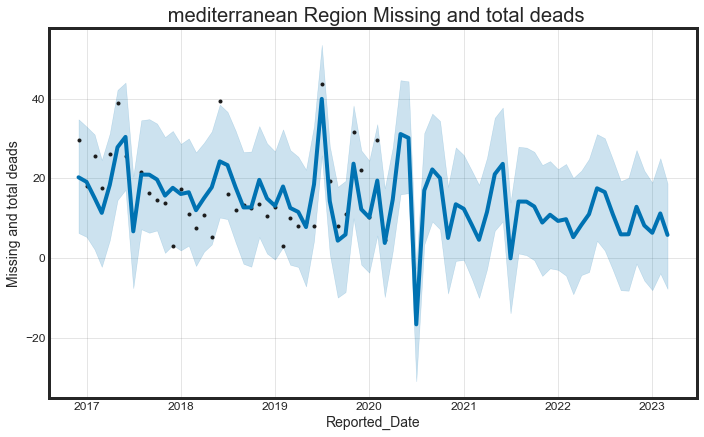

In [140]:


plt.figure(figsize=(18, 6))
mediterranean_model.plot(mediterranean_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' mediterranean Region Missing and total deads');

#### Understandings of the graph 

 Black dots showing the past data .when black dots end, forecasting area start for future .

## Observations

mediterranean region 

1. At the start  of 2020 , missing and toal dead value is slightly increasing and then dropping in mid 2020.



Text(0.5, 1.0, ' central_america Region Missing and total deads')

<Figure size 1296x432 with 0 Axes>

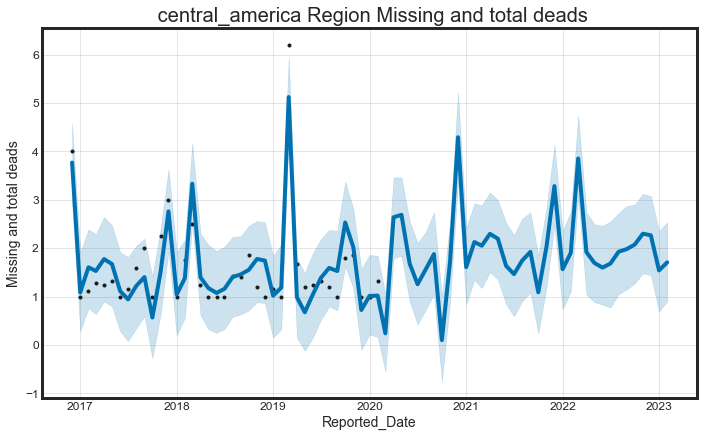

In [141]:

plt.figure(figsize=(18, 6))
central_america_model.plot(central_america_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' central_america Region Missing and total deads')

## Observations

central_america Region

1. Missing and total deads were highly increasing in beggining of 2019 while this probably due to the wave of migrants from central america at the time. However, its shapley dropping at the end of 2019 and our model predicting that it will in crease again from end of 2020.


Text(0.5, 1.0, ' US_Mexico_Border Region Missing and total deads')

<Figure size 1296x432 with 0 Axes>

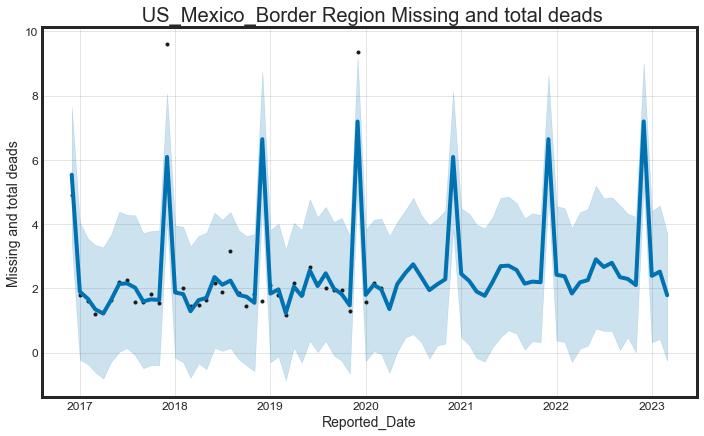

In [142]:
plt.figure(figsize=(18, 6))
US_Mexico_Border_model.plot(US_Mexico_Border_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' US_Mexico_Border Region Missing and total deads')

## Observations


1. Our model showing a pattern of increasing and decresing of missing and total deads numbers. This probably could be a result of some problems in our datasets or model.

Text(0.5, 1.0, ' Southeast_Asia Region Missing and total deads')

<Figure size 1440x720 with 0 Axes>

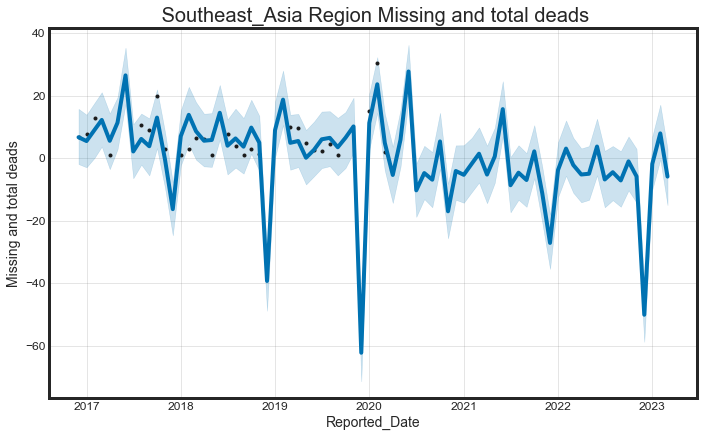

In [143]:
plt.figure(figsize=(20, 10))
Southeast_Asia_model.plot(Southeast_Asia_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' Southeast_Asia Region Missing and total deads')

## Observations

1. Our model is predicting a high drop of number of missing and total deads in Southeast_Asia region in 2020 but it forcasting a sharp rise at end of the year.

Text(0.5, 1.0, ' caribbean Region Missing and total deads')

<Figure size 1296x432 with 0 Axes>

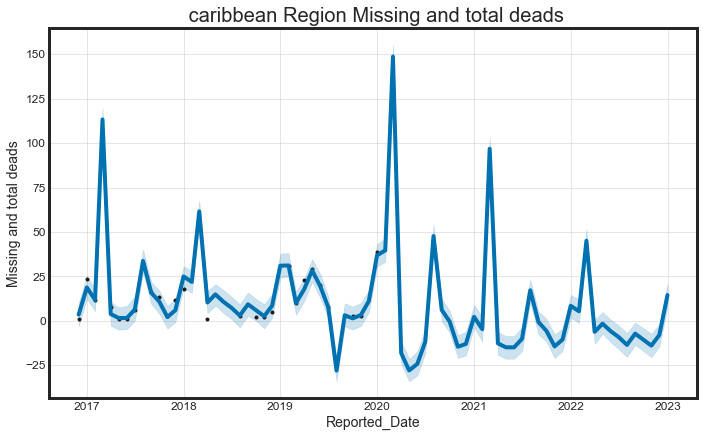

In [144]:
plt.figure(figsize=(18, 6))
caribbean_model.plot(caribbean_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' caribbean Region Missing and total deads')

## Observations

1. Model is predicting an increase of Missing and total deads in 2020 in caribbean

Text(0.5, 1.0, ' Europe Region Missing and total deads')

<Figure size 1296x432 with 0 Axes>

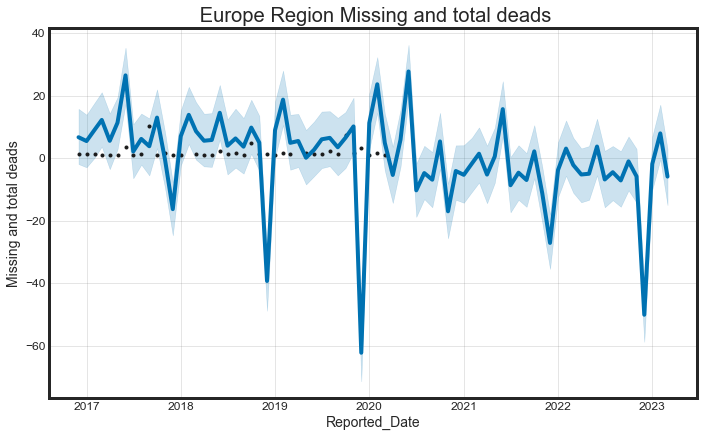

In [145]:
plt.figure(figsize=(18, 6))
europe_model.plot(Southeast_Asia_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' Europe Region Missing and total deads')


 ## Observations
 1. At the end of 2019 , missing and toal dead value is increasing while dropping in 2020 .
 2. in 2022,in the start value is below the zero,but at the end it will increase .

Text(0.5, 1.0, ' South_America Region Missing and total deads')

<Figure size 1296x432 with 0 Axes>

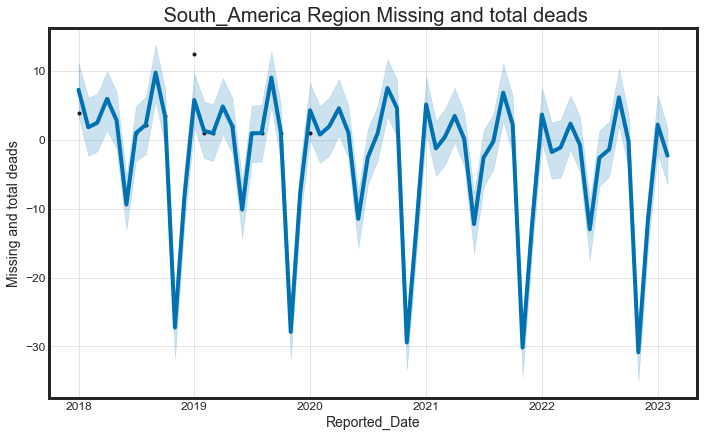

In [146]:
plt.figure(figsize=(18, 6))
South_America_model.plot(South_America_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title(' South_America Region Missing and total deads')

Text(0.5, 1.0, '  Horn_of_Africa Region Missing and total deads')

<Figure size 1296x432 with 0 Axes>

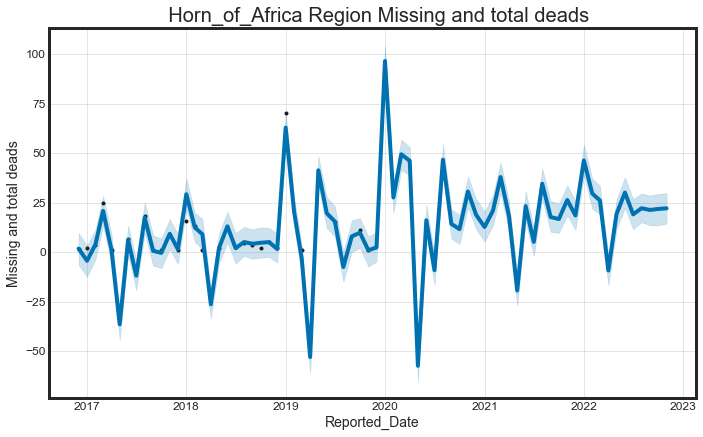

In [147]:
plt.figure(figsize=(18, 6))
Horn_of_Africa_model.plot(Horn_of_Africa_forecast, xlabel = 'Reported_Date', ylabel = 'Missing and total deads')
plt.title('  Horn_of_Africa Region Missing and total deads')

 ## Observations
1. Our model is showing a massive increasing of Missing and total deads number in east africa regions in 2020.


**8 Summary of findings**

This analysis was an attempt to predict the number of migrant death thought forecasting the dangerous routes used by migrants and the main causes of death per regions using regression models and machine learning methods.
The primarily result from linear regression was not satisfactory and therefore Decision tree 
Gradient-Boosted Tree Regressors were used and the outcome were more reasonable. The models predict a slight increment in number of dead and missing migrants throughout the coming years. Logistics regression on the other hand indicated that migrants’ routes from central America and central Mediterranean regions are the most dangerous routes with high probability of death caused by either Hyperthermia or drawings. 
One of the downsides of this analysis is the quality of the dataset. Given the high number of missing values and the dropped values from data cleaning the accuracy of ML models are presumed not quite precise. Although, the results from time series analysis were more visible. Overall, this set of ML can give a decent forecasting of the number of missing dead migrants across several regions in the world. 

